In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
import optuna
import random
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

c:\Users\athar\anaconda3\envs\ds_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
file_paths = {
    "NVIDIA": "../data/nvidia_stock_features_selected.csv",
    "Microsoft": "../data/microsoft_stock_features_selected.csv",
    "Apple": "../data/apple_stock_features_selected.csv",
}

features = ["Close", "High", "Low", "Open", "Volume", "SMA_20", "EMA_20", "SMA_50", "EMA_50", "SMA_200", "EMA_200"]
target = "Close"

In [4]:
def load_and_preprocess_data(stock):
    df = pd.read_csv(file_paths[stock], parse_dates=["Date"], index_col="Date")
    
    # Normalize feature columns
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Convert to numpy
    data_np = df[features].values
    target_np = df[target].values

    return data_np, target_np

In [5]:
def create_edge_index(num_nodes):
    """Creates sequential edges between time steps."""
    edge_index = []
    for i in range(num_nodes - 1):  # Only valid connections
        edge_index.append([i, i + 1])
        edge_index.append([i + 1, i])

    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

In [6]:
def create_graph_data(stock):
    """Converts stock data into PyTorch Geometric graph format."""
    data_np, target_np = load_and_preprocess_data(stock)
    num_nodes = len(data_np)

    # Create edge index
    edge_index = create_edge_index(num_nodes)

    # Convert to PyTorch tensors
    x = torch.tensor(data_np, dtype=torch.float)
    y = torch.tensor(target_np, dtype=torch.float).view(-1, 1)

    # Create graph data object
    return Data(x=x, edge_index=edge_index, y=y)

In [7]:
class LSTM_TGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout_rate=0.0):
        super(LSTM_TGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        
        dropout = dropout_rate if num_layers > 1 else 0.0
        
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.relu(self.gcn1(x, edge_index))
        x = self.dropout(x)
        x = self.relu(self.gcn2(x, edge_index))

        x = x.view(1, x.shape[0], x.shape[1])  # Reshape for LSTM (batch, seq, features)
        x, _ = self.lstm(x)
        x = self.fc(x.squeeze(0))  # Fully connected layer
        return x


In [8]:
def train_lstm_tgnn(stock_name, hidden_dim=64, num_layers=2, dropout_rate=0.0, epochs=50, learning_rate=0.001, plot=False):
    """Trains the LSTM + T-GNN model and returns MSE and R2 without plotting unless explicitly requested."""
    print(f"\n=== Training LSTM + T-GNN for {stock_name} ===")

    # Load graph data
    graph_data = create_graph_data(stock_name)

    # Create separate edge indices for train and test
    train_size = int(0.8 * len(graph_data.x))
    train_data = Data(
        x=graph_data.x[:train_size], 
        edge_index=create_edge_index(train_size),  
        y=graph_data.y[:train_size]
    )
    test_data = Data(
        x=graph_data.x[train_size:], 
        edge_index=create_edge_index(len(graph_data.x) - train_size),  
        y=graph_data.y[train_size:]
    )

    # Initialize model
    model = LSTM_TGNN(len(features), hidden_dim, 1, num_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_data)
        loss = criterion(output, train_data.y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(test_data).numpy().flatten()
        actuals = test_data.y.numpy().flatten()

    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f"\nEvaluation for {stock_name}:")
    print(f"MSE: {mse:.6f}")
    print(f"R2 Score: {r2:.6f}")


    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label="Actual", alpha=0.7)
    plt.plot(predictions, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title(f"LSTM + T-GNN Prediction ({stock_name})")
    plt.show()

    return {"Stock": stock, "MSE":mse, "R2":r2}


=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/50, Loss: 0.000373
Epoch 20/50, Loss: 0.000106
Epoch 30/50, Loss: 0.000078
Epoch 40/50, Loss: 0.000041
Epoch 50/50, Loss: 0.000011

Evaluation for NVIDIA:
MSE: 0.035623
R2 Score: 0.513169


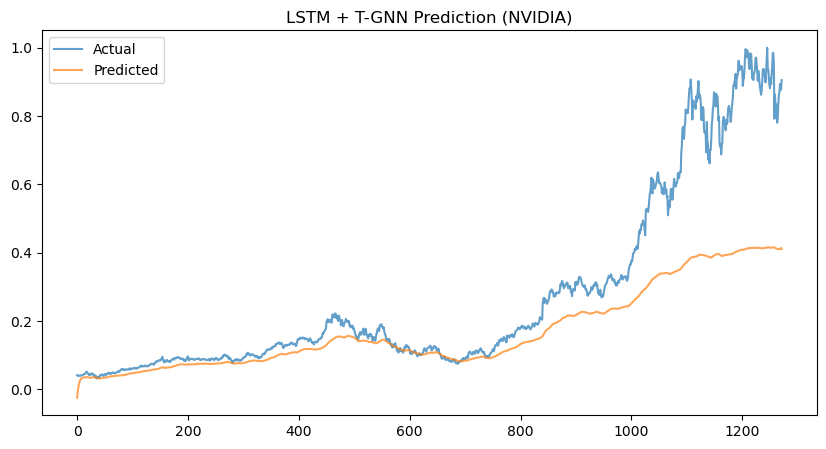


=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/50, Loss: 0.000788
Epoch 20/50, Loss: 0.000631
Epoch 30/50, Loss: 0.000273
Epoch 40/50, Loss: 0.000057
Epoch 50/50, Loss: 0.000010

Evaluation for Microsoft:
MSE: 0.035723
R2 Score: 0.399326



=== Training LSTM + T-GNN for Apple ===
Epoch 10/50, Loss: 0.000603
Epoch 20/50, Loss: 0.000117
Epoch 30/50, Loss: 0.000021
Epoch 40/50, Loss: 0.000026
Epoch 50/50, Loss: 0.000013

Evaluation for Apple:
MSE: 0.028551
R2 Score: 0.553377


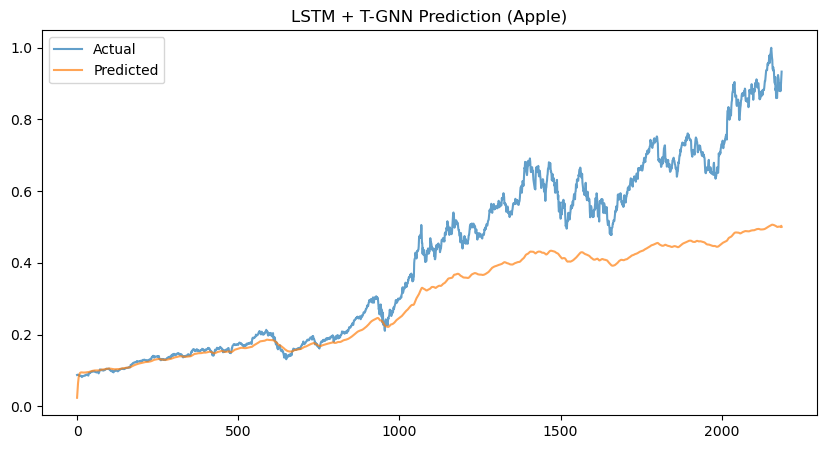

In [10]:
baseline_results = {stock: train_lstm_tgnn(stock) for stock in file_paths}

[I 2025-03-09 22:24:33,398] A new study created in memory with name: no-name-a453f3ea-4bf1-48ad-a6b6-399b36fc6766



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/93, Loss: 0.015438
Epoch 20/93, Loss: 0.013219
Epoch 30/93, Loss: 0.011234
Epoch 40/93, Loss: 0.009462
Epoch 50/93, Loss: 0.007879
Epoch 60/93, Loss: 0.006467
Epoch 70/93, Loss: 0.005210
Epoch 80/93, Loss: 0.004099
Epoch 90/93, Loss: 0.003130

Evaluation for NVIDIA:
MSE: 0.167325
R2 Score: -1.286725


[I 2025-03-09 22:24:36,691] Trial 0 finished with value: 0.16732513904571533 and parameters: {'learning_rate': 0.00010481702453171415, 'hidden_dim': 32, 'dropout_rate': 0.39345854181794815, 'epochs': 93, 'num_layers': 1}. Best is trial 0 with value: 0.16732513904571533.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/97, Loss: 0.001041
Epoch 20/97, Loss: 0.000166
Epoch 30/97, Loss: 0.000118
Epoch 40/97, Loss: 0.000114
Epoch 50/97, Loss: 0.000072
Epoch 60/97, Loss: 0.000014
Epoch 70/97, Loss: 0.000009
Epoch 80/97, Loss: 0.000003
Epoch 90/97, Loss: 0.000002

Evaluation for NVIDIA:
MSE: 0.030030
R2 Score: 0.589595


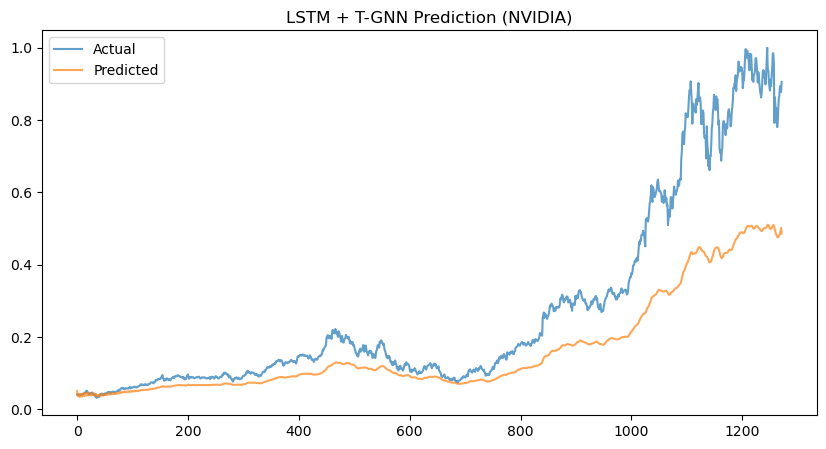

[I 2025-03-09 22:25:05,390] Trial 1 finished with value: 0.030030352994799614 and parameters: {'learning_rate': 0.006844906367407788, 'hidden_dim': 256, 'dropout_rate': 0.2677823609617754, 'epochs': 97, 'num_layers': 1}. Best is trial 1 with value: 0.030030352994799614.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/83, Loss: 0.000163
Epoch 20/83, Loss: 0.000189
Epoch 30/83, Loss: 0.000101
Epoch 40/83, Loss: 0.000098
Epoch 50/83, Loss: 0.000075
Epoch 60/83, Loss: 0.000063
Epoch 70/83, Loss: 0.000050
Epoch 80/83, Loss: 0.000036

Evaluation for NVIDIA:
MSE: 0.077958
R2 Score: -0.065403


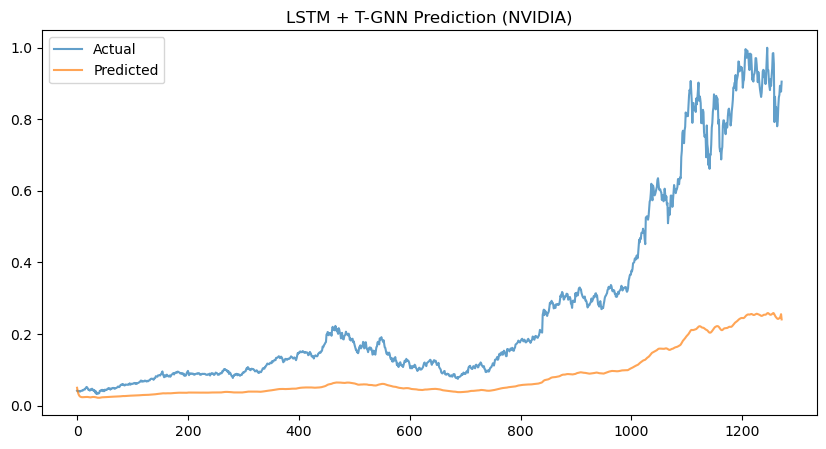

[I 2025-03-09 22:25:15,481] Trial 2 finished with value: 0.0779581218957901 and parameters: {'learning_rate': 0.00012172884151315365, 'hidden_dim': 128, 'dropout_rate': 0.37187776587508903, 'epochs': 83, 'num_layers': 1}. Best is trial 1 with value: 0.030030352994799614.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/75, Loss: 0.000537
Epoch 20/75, Loss: 0.000255
Epoch 30/75, Loss: 0.000149
Epoch 40/75, Loss: 0.000106
Epoch 50/75, Loss: 0.000066
Epoch 60/75, Loss: 0.000015
Epoch 70/75, Loss: 0.000005

Evaluation for NVIDIA:
MSE: 0.020096
R2 Score: 0.725365


[I 2025-03-09 22:25:19,691] Trial 3 finished with value: 0.020095689222216606 and parameters: {'learning_rate': 0.004753900340238262, 'hidden_dim': 64, 'dropout_rate': 0.2779672124865773, 'epochs': 75, 'num_layers': 1}. Best is trial 3 with value: 0.020095689222216606.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/60, Loss: 0.001128
Epoch 20/60, Loss: 0.000206
Epoch 30/60, Loss: 0.000197
Epoch 40/60, Loss: 0.000190
Epoch 50/60, Loss: 0.000149
Epoch 60/60, Loss: 0.000154

Evaluation for NVIDIA:
MSE: 0.143543
R2 Score: -0.961705


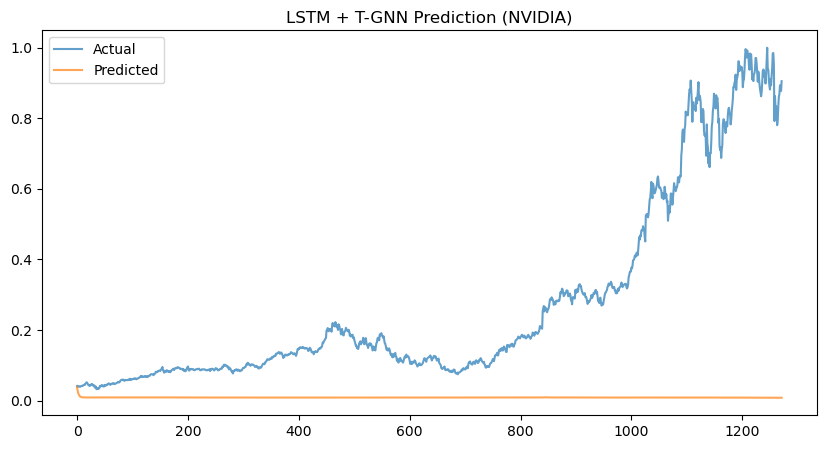

[I 2025-03-09 22:25:23,543] Trial 4 finished with value: 0.14354266226291656 and parameters: {'learning_rate': 0.0002000293988551429, 'hidden_dim': 32, 'dropout_rate': 0.4581786912992042, 'epochs': 60, 'num_layers': 2}. Best is trial 3 with value: 0.020095689222216606.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/98, Loss: 0.000217
Epoch 20/98, Loss: 0.000282
Epoch 30/98, Loss: 0.000161
Epoch 40/98, Loss: 0.000134
Epoch 50/98, Loss: 0.000124
Epoch 60/98, Loss: 0.000120
Epoch 70/98, Loss: 0.000120
Epoch 80/98, Loss: 0.000120
Epoch 90/98, Loss: 0.000118

Evaluation for NVIDIA:
MSE: 0.144832
R2 Score: -0.979325


[I 2025-03-09 22:25:37,444] Trial 5 finished with value: 0.14483195543289185 and parameters: {'learning_rate': 0.005467449082330476, 'hidden_dim': 64, 'dropout_rate': 0.3032287105238585, 'epochs': 98, 'num_layers': 3}. Best is trial 3 with value: 0.020095689222216606.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/89, Loss: 0.000422
Epoch 20/89, Loss: 0.000215
Epoch 30/89, Loss: 0.000131
Epoch 40/89, Loss: 0.000085
Epoch 50/89, Loss: 0.000047
Epoch 60/89, Loss: 0.000018
Epoch 70/89, Loss: 0.000008
Epoch 80/89, Loss: 0.000005

Evaluation for NVIDIA:
MSE: 0.042167
R2 Score: 0.423733


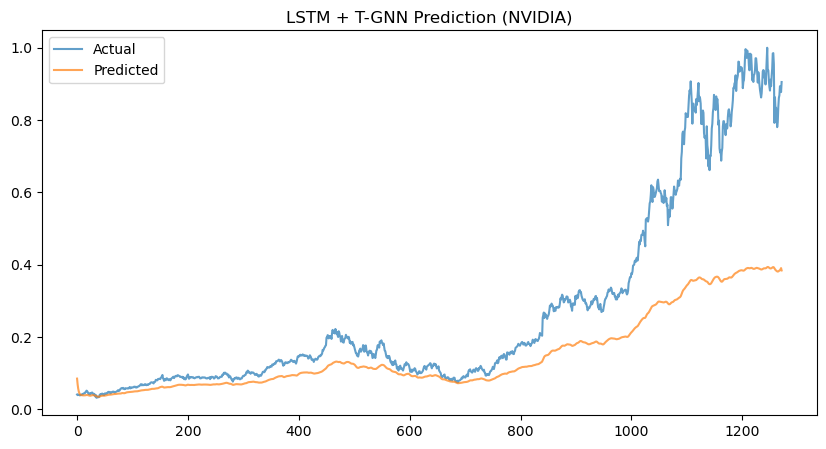

[I 2025-03-09 22:25:40,653] Trial 6 finished with value: 0.04216686263680458 and parameters: {'learning_rate': 0.0018378750544963964, 'hidden_dim': 32, 'dropout_rate': 0.36691051470722325, 'epochs': 89, 'num_layers': 1}. Best is trial 3 with value: 0.020095689222216606.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/55, Loss: 0.000281
Epoch 20/55, Loss: 0.000016
Epoch 30/55, Loss: 0.000028
Epoch 40/55, Loss: 0.000004
Epoch 50/55, Loss: 0.000006

Evaluation for NVIDIA:
MSE: 0.002152
R2 Score: 0.970585


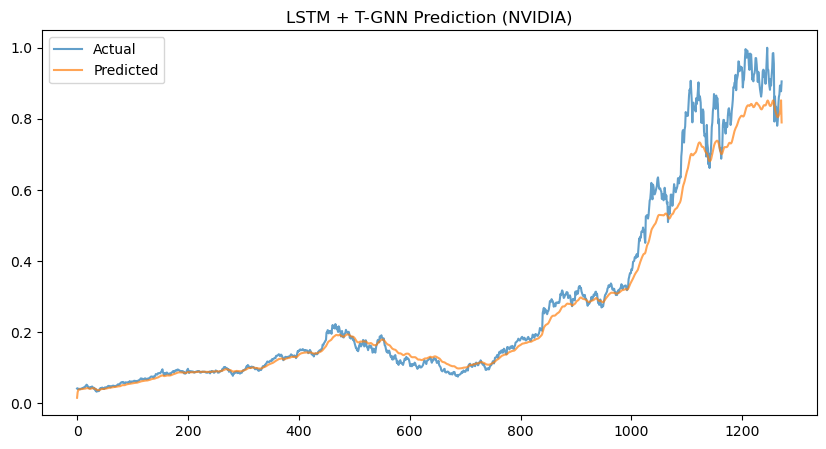

[I 2025-03-09 22:25:56,459] Trial 7 finished with value: 0.0021523884497582912 and parameters: {'learning_rate': 0.0009547069800389936, 'hidden_dim': 256, 'dropout_rate': 0.19653775592819278, 'epochs': 55, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/65, Loss: 0.007371
Epoch 20/65, Loss: 0.002137
Epoch 30/65, Loss: 0.000264
Epoch 40/65, Loss: 0.000376
Epoch 50/65, Loss: 0.000277
Epoch 60/65, Loss: 0.000203

Evaluation for NVIDIA:
MSE: 0.147962
R2 Score: -1.022097


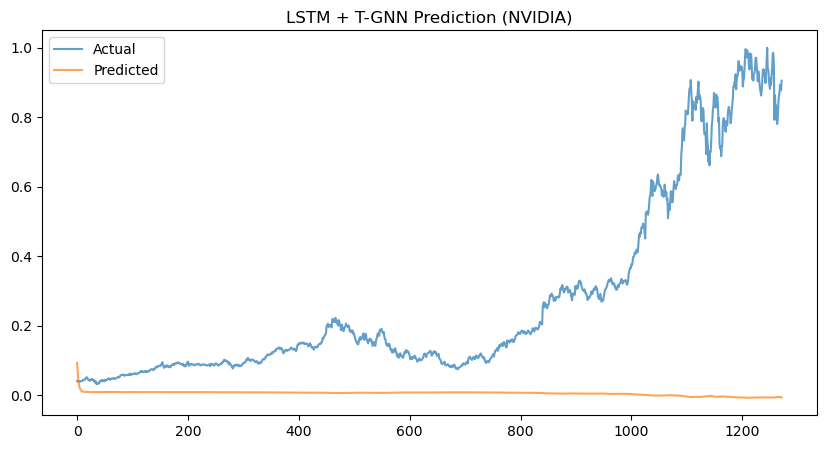

[I 2025-03-09 22:26:00,520] Trial 8 finished with value: 0.14796169102191925 and parameters: {'learning_rate': 0.00032639842548110953, 'hidden_dim': 32, 'dropout_rate': 0.4735683567080412, 'epochs': 65, 'num_layers': 2}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/62, Loss: 0.001109
Epoch 20/62, Loss: 0.000346
Epoch 30/62, Loss: 0.000127
Epoch 40/62, Loss: 0.000110
Epoch 50/62, Loss: 0.000101
Epoch 60/62, Loss: 0.000079

Evaluation for NVIDIA:
MSE: 0.099352
R2 Score: -0.357777


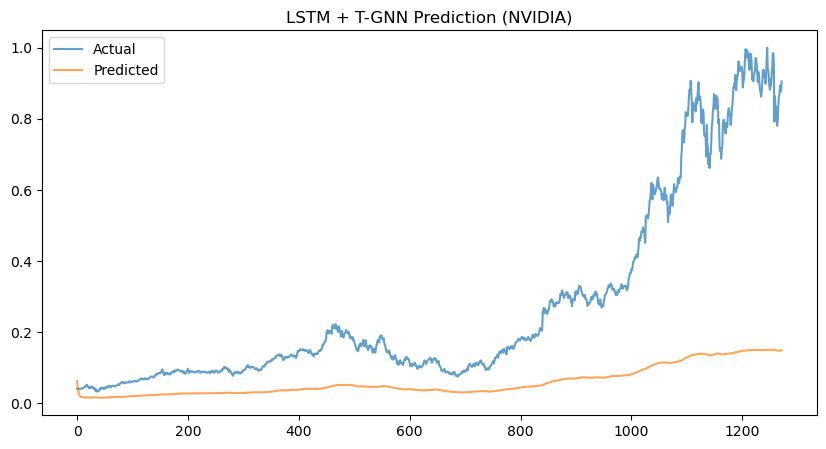

[I 2025-03-09 22:26:06,739] Trial 9 finished with value: 0.09935177862644196 and parameters: {'learning_rate': 0.0007407486647295038, 'hidden_dim': 64, 'dropout_rate': 0.18044494221129295, 'epochs': 62, 'num_layers': 2}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/51, Loss: 0.000210
Epoch 20/51, Loss: 0.000195
Epoch 30/51, Loss: 0.000124
Epoch 40/51, Loss: 0.000097
Epoch 50/51, Loss: 0.000017

Evaluation for NVIDIA:
MSE: 0.063967
R2 Score: 0.125811


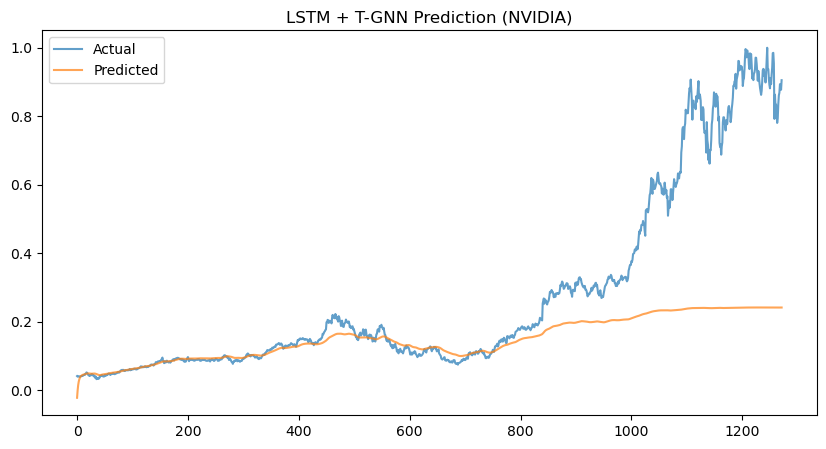

[I 2025-03-09 22:26:45,908] Trial 10 finished with value: 0.06396652013063431 and parameters: {'learning_rate': 0.0012856201576631407, 'hidden_dim': 256, 'dropout_rate': 0.11267654961314807, 'epochs': 51, 'num_layers': 3}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/76, Loss: 0.000476
Epoch 20/76, Loss: 0.000098
Epoch 30/76, Loss: 0.000074
Epoch 40/76, Loss: 0.000021
Epoch 50/76, Loss: 0.000009
Epoch 60/76, Loss: 0.000006
Epoch 70/76, Loss: 0.000003

Evaluation for NVIDIA:
MSE: 0.019398
R2 Score: 0.734904


[I 2025-03-09 22:26:49,798] Trial 11 finished with value: 0.019397707656025887 and parameters: {'learning_rate': 0.003406161076133132, 'hidden_dim': 64, 'dropout_rate': 0.21874126708665287, 'epochs': 76, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/74, Loss: 0.000374
Epoch 20/74, Loss: 0.000198
Epoch 30/74, Loss: 0.000063
Epoch 40/74, Loss: 0.000016
Epoch 50/74, Loss: 0.000006
Epoch 60/74, Loss: 0.000003
Epoch 70/74, Loss: 0.000001

Evaluation for NVIDIA:
MSE: 0.007223
R2 Score: 0.901288


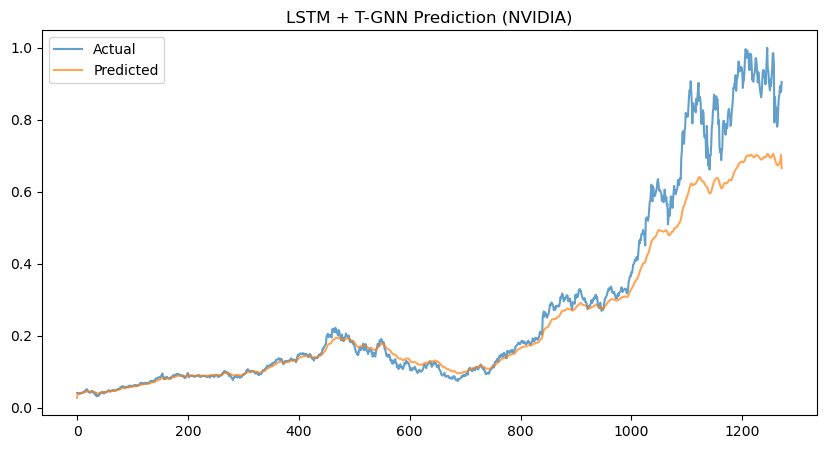

[I 2025-03-09 22:27:10,400] Trial 12 finished with value: 0.007222975604236126 and parameters: {'learning_rate': 0.002292870557765235, 'hidden_dim': 256, 'dropout_rate': 0.1938874334530692, 'epochs': 74, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/54, Loss: 0.000513
Epoch 20/54, Loss: 0.000265
Epoch 30/54, Loss: 0.000136
Epoch 40/54, Loss: 0.000055
Epoch 50/54, Loss: 0.000008

Evaluation for NVIDIA:
MSE: 0.021601
R2 Score: 0.704789


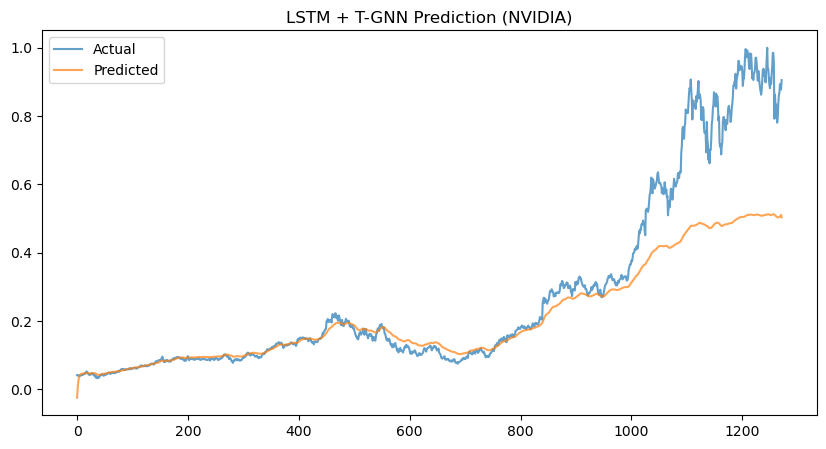

[I 2025-03-09 22:27:37,849] Trial 13 finished with value: 0.02160126529633999 and parameters: {'learning_rate': 0.0006542616172441781, 'hidden_dim': 256, 'dropout_rate': 0.1426812139033988, 'epochs': 54, 'num_layers': 2}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/71, Loss: 0.000117
Epoch 20/71, Loss: 0.000145
Epoch 30/71, Loss: 0.000040
Epoch 40/71, Loss: 0.000010
Epoch 50/71, Loss: 0.000003
Epoch 60/71, Loss: 0.000002
Epoch 70/71, Loss: 0.000002

Evaluation for NVIDIA:
MSE: 0.008381
R2 Score: 0.885464


[I 2025-03-09 22:27:57,235] Trial 14 finished with value: 0.00838088896125555 and parameters: {'learning_rate': 0.002146179436229109, 'hidden_dim': 256, 'dropout_rate': 0.20824772107136555, 'epochs': 71, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/84, Loss: 0.000363
Epoch 20/84, Loss: 0.000225
Epoch 30/84, Loss: 0.000131
Epoch 40/84, Loss: 0.000066
Epoch 50/84, Loss: 0.000010
Epoch 60/84, Loss: 0.000009
Epoch 70/84, Loss: 0.000004
Epoch 80/84, Loss: 0.000004

Evaluation for NVIDIA:
MSE: 0.024895
R2 Score: 0.659774


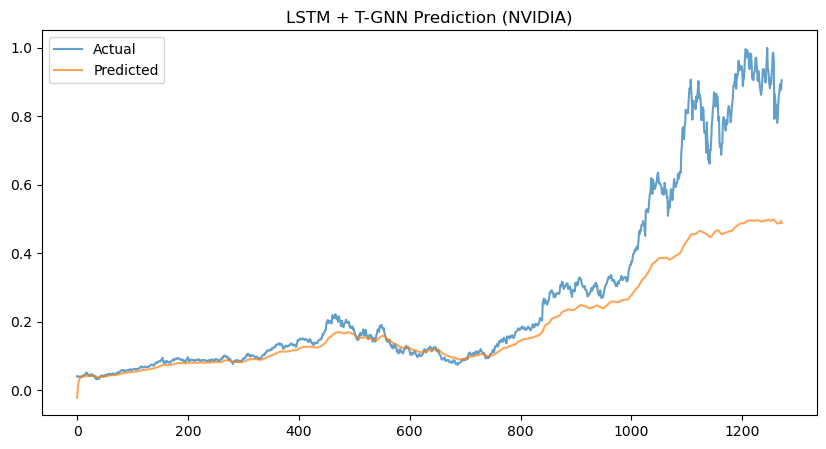

[I 2025-03-09 22:28:40,265] Trial 15 finished with value: 0.02489517256617546 and parameters: {'learning_rate': 0.0004837175433531148, 'hidden_dim': 256, 'dropout_rate': 0.1618823566846247, 'epochs': 84, 'num_layers': 2}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/68, Loss: 0.000122
Epoch 20/68, Loss: 0.000035
Epoch 30/68, Loss: 0.000017
Epoch 40/68, Loss: 0.000006
Epoch 50/68, Loss: 0.000003
Epoch 60/68, Loss: 0.000002

Evaluation for NVIDIA:
MSE: 0.008213
R2 Score: 0.887755


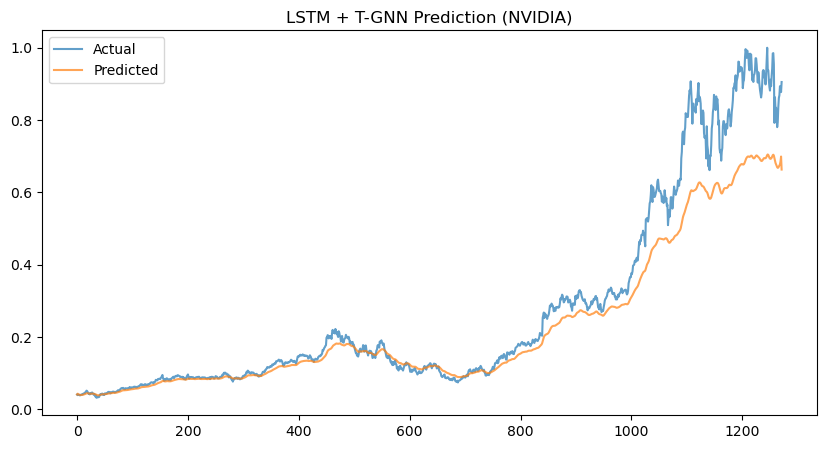

[I 2025-03-09 22:28:48,655] Trial 16 finished with value: 0.008213240653276443 and parameters: {'learning_rate': 0.0012462728553148752, 'hidden_dim': 128, 'dropout_rate': 0.10032050611888035, 'epochs': 68, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/57, Loss: 0.000734
Epoch 20/57, Loss: 0.000185
Epoch 30/57, Loss: 0.000152
Epoch 40/57, Loss: 0.000118
Epoch 50/57, Loss: 0.000112

Evaluation for NVIDIA:
MSE: 0.142892
R2 Score: -0.952815


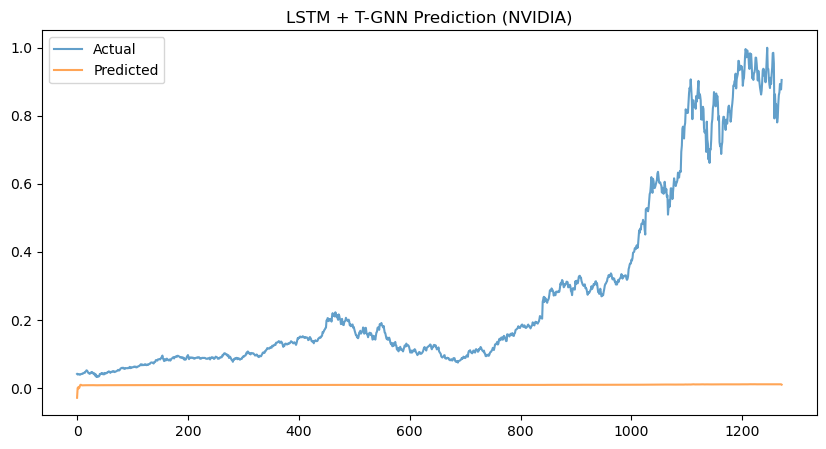

[I 2025-03-09 22:29:32,121] Trial 17 finished with value: 0.14289219677448273 and parameters: {'learning_rate': 0.0029180221112199024, 'hidden_dim': 256, 'dropout_rate': 0.24455652408856576, 'epochs': 57, 'num_layers': 3}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/79, Loss: 0.000400
Epoch 20/79, Loss: 0.000184
Epoch 30/79, Loss: 0.000031
Epoch 40/79, Loss: 0.000011
Epoch 50/79, Loss: 0.000005
Epoch 60/79, Loss: 0.000003
Epoch 70/79, Loss: 0.000002

Evaluation for NVIDIA:
MSE: 0.003291
R2 Score: 0.955027


[I 2025-03-09 22:29:53,814] Trial 18 finished with value: 0.0032907603308558464 and parameters: {'learning_rate': 0.0010070668692167507, 'hidden_dim': 256, 'dropout_rate': 0.3174730169403977, 'epochs': 79, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/83, Loss: 0.000118
Epoch 20/83, Loss: 0.000109
Epoch 30/83, Loss: 0.000047
Epoch 40/83, Loss: 0.000013
Epoch 50/83, Loss: 0.000006
Epoch 60/83, Loss: 0.000006
Epoch 70/83, Loss: 0.000005
Epoch 80/83, Loss: 0.000004

Evaluation for NVIDIA:
MSE: 0.021346
R2 Score: 0.708283


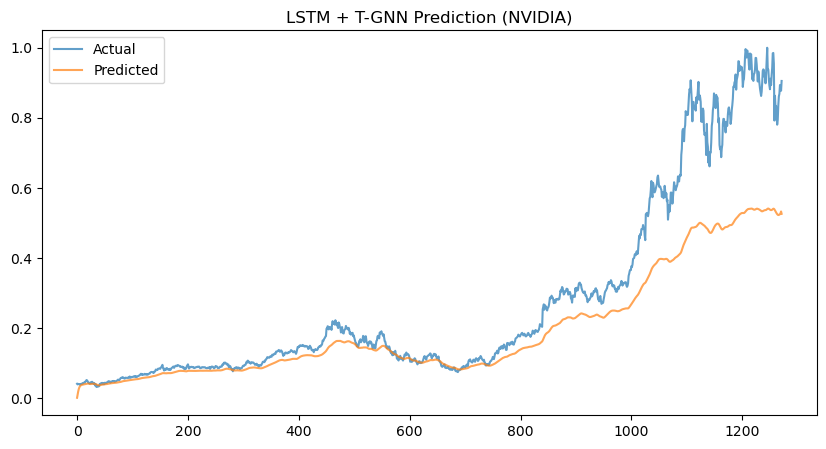

[I 2025-03-09 22:30:36,100] Trial 19 finished with value: 0.021345609799027443 and parameters: {'learning_rate': 0.0003105159374428617, 'hidden_dim': 256, 'dropout_rate': 0.31969304041867336, 'epochs': 83, 'num_layers': 2}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/79, Loss: 0.001208
Epoch 20/79, Loss: 0.000239
Epoch 30/79, Loss: 0.000132
Epoch 40/79, Loss: 0.000124
Epoch 50/79, Loss: 0.000119
Epoch 60/79, Loss: 0.000114
Epoch 70/79, Loss: 0.000102

Evaluation for NVIDIA:
MSE: 0.130879
R2 Score: -0.788645


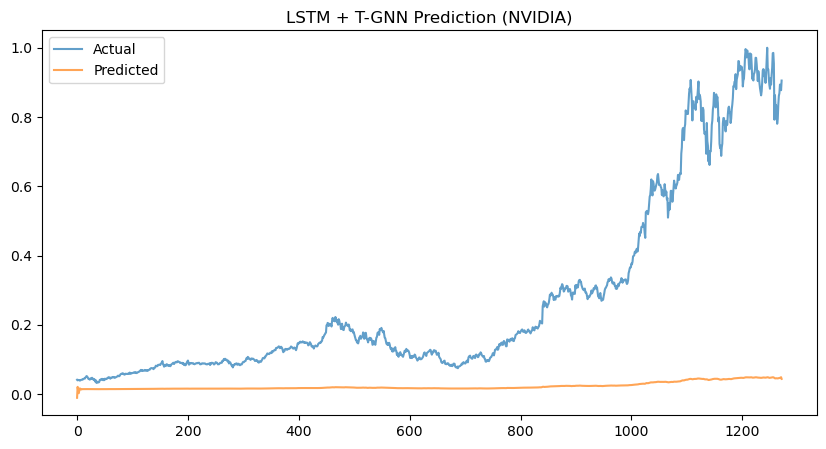

[I 2025-03-09 22:30:52,481] Trial 20 finished with value: 0.1308794766664505 and parameters: {'learning_rate': 0.00920000600731109, 'hidden_dim': 128, 'dropout_rate': 0.33748974864451997, 'epochs': 79, 'num_layers': 2}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/70, Loss: 0.000262
Epoch 20/70, Loss: 0.000013
Epoch 30/70, Loss: 0.000022
Epoch 40/70, Loss: 0.000004
Epoch 50/70, Loss: 0.000005
Epoch 60/70, Loss: 0.000002
Epoch 70/70, Loss: 0.000001

Evaluation for NVIDIA:
MSE: 0.004215
R2 Score: 0.942395


[I 2025-03-09 22:31:12,126] Trial 21 finished with value: 0.0042150733061134815 and parameters: {'learning_rate': 0.0009456055018905117, 'hidden_dim': 256, 'dropout_rate': 0.2202000366811349, 'epochs': 70, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/69, Loss: 0.000213
Epoch 20/69, Loss: 0.000003
Epoch 30/69, Loss: 0.000018
Epoch 40/69, Loss: 0.000004
Epoch 50/69, Loss: 0.000004
Epoch 60/69, Loss: 0.000002

Evaluation for NVIDIA:
MSE: 0.004308
R2 Score: 0.941124


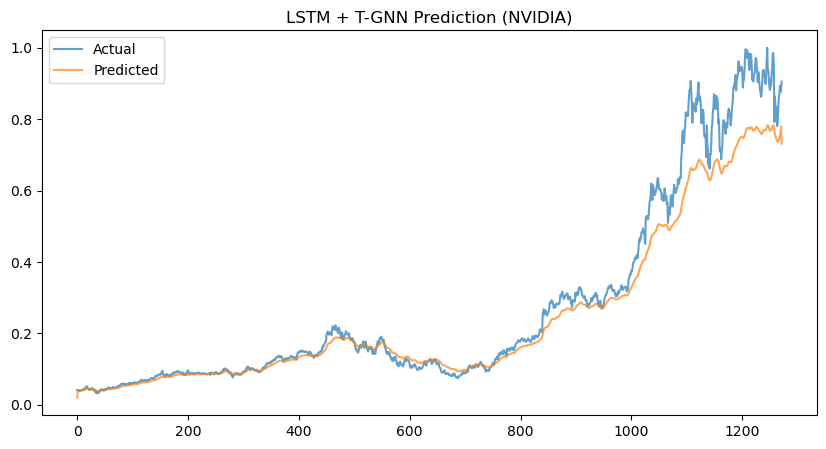

[I 2025-03-09 22:31:31,204] Trial 22 finished with value: 0.004308100789785385 and parameters: {'learning_rate': 0.00090097827267619, 'hidden_dim': 256, 'dropout_rate': 0.23552680838128634, 'epochs': 69, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/64, Loss: 0.000064
Epoch 20/64, Loss: 0.000020
Epoch 30/64, Loss: 0.000004
Epoch 40/64, Loss: 0.000002
Epoch 50/64, Loss: 0.000002
Epoch 60/64, Loss: 0.000001

Evaluation for NVIDIA:
MSE: 0.002477
R2 Score: 0.966155


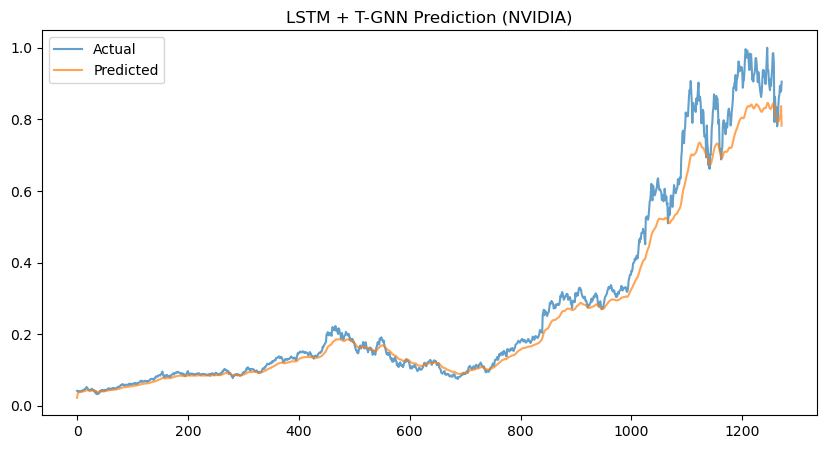

[I 2025-03-09 22:31:48,788] Trial 23 finished with value: 0.0024765089619904757 and parameters: {'learning_rate': 0.00048006408386880344, 'hidden_dim': 256, 'dropout_rate': 0.26289165276714566, 'epochs': 64, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.



=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/50, Loss: 0.000070
Epoch 20/50, Loss: 0.000014
Epoch 30/50, Loss: 0.000004
Epoch 40/50, Loss: 0.000004
Epoch 50/50, Loss: 0.000001

Evaluation for NVIDIA:
MSE: 0.003559
R2 Score: 0.951360


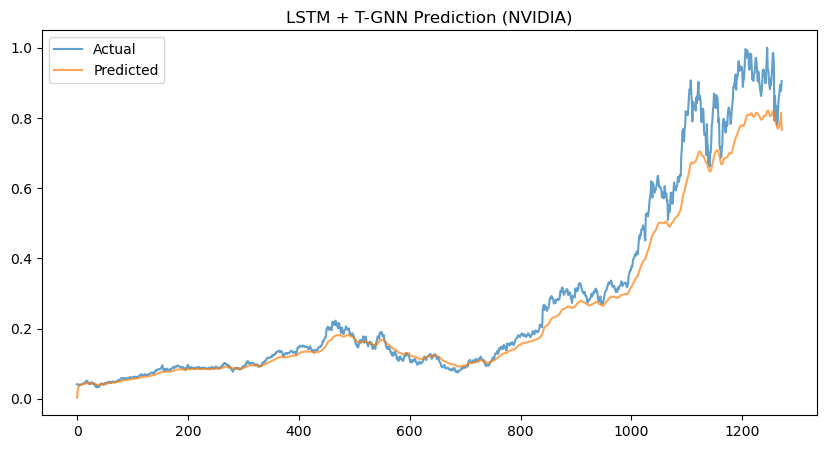

[I 2025-03-09 22:32:02,519] Trial 24 finished with value: 0.0035590745974332094 and parameters: {'learning_rate': 0.0004227345244316612, 'hidden_dim': 256, 'dropout_rate': 0.41666743863611394, 'epochs': 50, 'num_layers': 1}. Best is trial 7 with value: 0.0021523884497582912.
[I 2025-03-09 22:32:02,520] A new study created in memory with name: no-name-06e64315-24df-4558-977a-695ad5670eae


Best parameters for NVIDIA: {'learning_rate': 0.0009547069800389936, 'hidden_dim': 256, 'dropout_rate': 0.19653775592819278, 'epochs': 55, 'num_layers': 1}

=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/95, Loss: 0.000973
Epoch 20/95, Loss: 0.000633
Epoch 30/95, Loss: 0.000222
Epoch 40/95, Loss: 0.000068
Epoch 50/95, Loss: 0.000027
Epoch 60/95, Loss: 0.000029
Epoch 70/95, Loss: 0.000019
Epoch 80/95, Loss: 0.000016
Epoch 90/95, Loss: 0.000016

Evaluation for Microsoft:
MSE: 0.029643
R2 Score: 0.501559


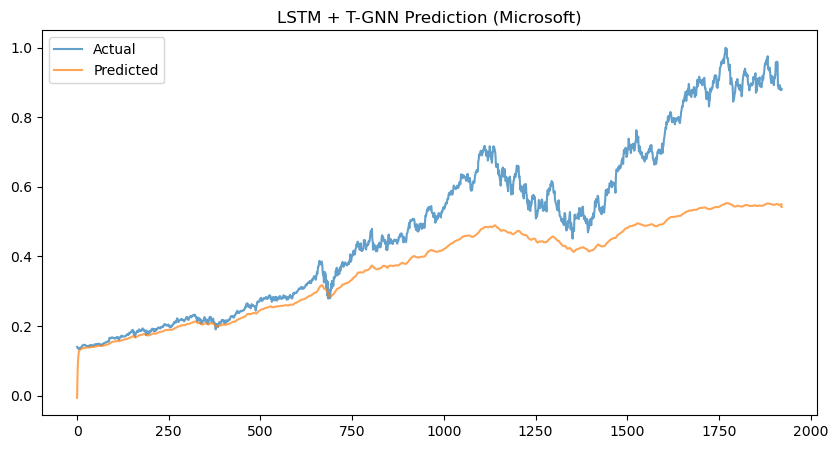

[I 2025-03-09 22:33:17,771] Trial 0 finished with value: 0.029642704874277115 and parameters: {'learning_rate': 0.0006731426345892064, 'hidden_dim': 256, 'dropout_rate': 0.3207291560942035, 'epochs': 95, 'num_layers': 2}. Best is trial 0 with value: 0.029642704874277115.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/60, Loss: 0.000922
Epoch 20/60, Loss: 0.000892
Epoch 30/60, Loss: 0.000880
Epoch 40/60, Loss: 0.000856
Epoch 50/60, Loss: 0.000826
Epoch 60/60, Loss: 0.000767

Evaluation for Microsoft:
MSE: 0.236726
R2 Score: -2.980535


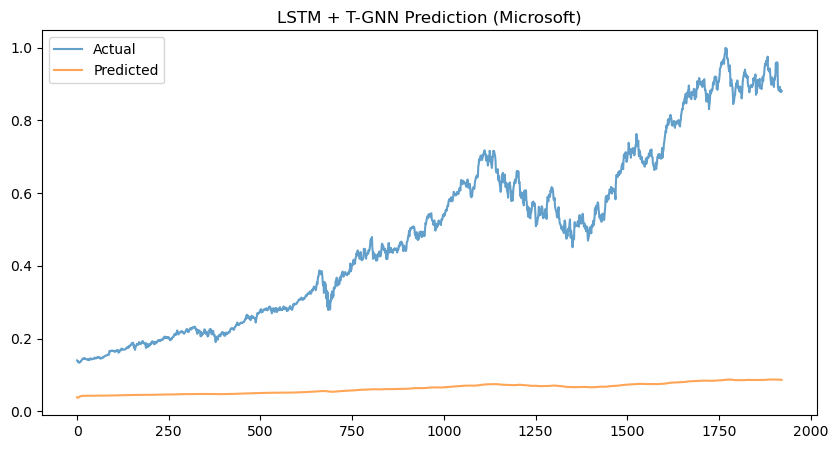

[I 2025-03-09 22:33:26,059] Trial 1 finished with value: 0.2367255687713623 and parameters: {'learning_rate': 0.00021753641653397032, 'hidden_dim': 32, 'dropout_rate': 0.43644237322006874, 'epochs': 60, 'num_layers': 3}. Best is trial 0 with value: 0.029642704874277115.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/97, Loss: 0.001261
Epoch 20/97, Loss: 0.000811
Epoch 30/97, Loss: 0.000449
Epoch 40/97, Loss: 0.000065
Epoch 50/97, Loss: 0.000055
Epoch 60/97, Loss: 0.000013
Epoch 70/97, Loss: 0.000015
Epoch 80/97, Loss: 0.000009
Epoch 90/97, Loss: 0.000008

Evaluation for Microsoft:
MSE: 0.002403
R2 Score: 0.959599


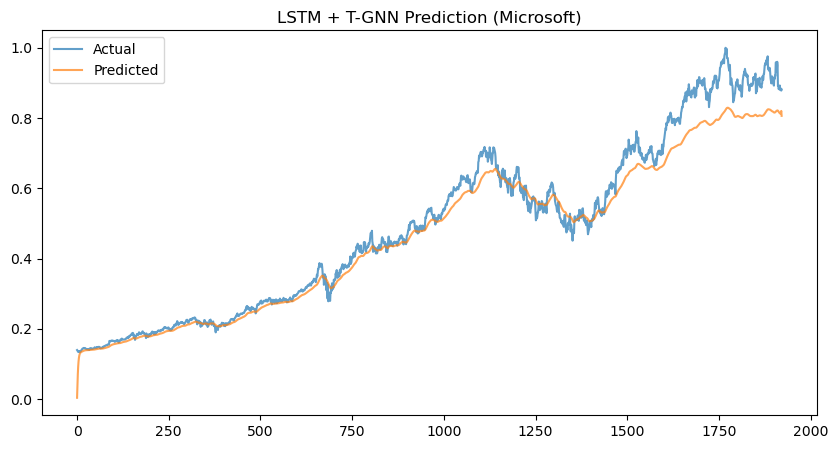

[I 2025-03-09 22:34:46,418] Trial 2 finished with value: 0.0024027074687182903 and parameters: {'learning_rate': 0.00022729721027655558, 'hidden_dim': 256, 'dropout_rate': 0.11285333470413571, 'epochs': 97, 'num_layers': 2}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/63, Loss: 0.001733
Epoch 20/63, Loss: 0.000910
Epoch 30/63, Loss: 0.000275
Epoch 40/63, Loss: 0.000095
Epoch 50/63, Loss: 0.000042
Epoch 60/63, Loss: 0.000021

Evaluation for Microsoft:
MSE: 0.127874
R2 Score: -1.150191


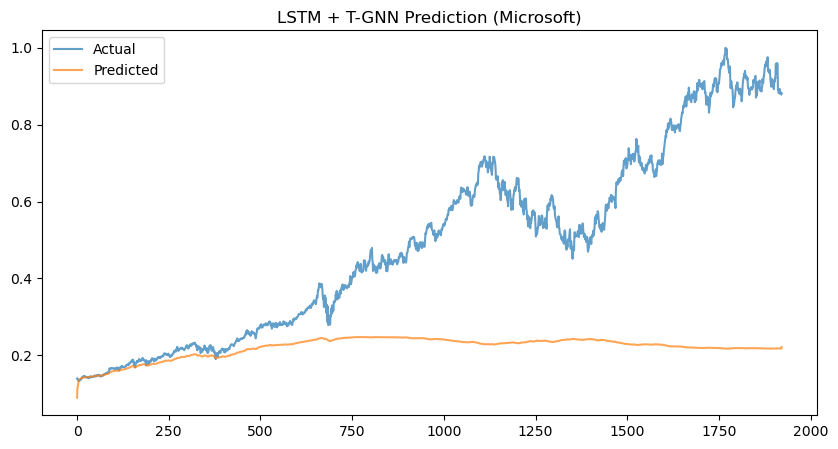

[I 2025-03-09 22:35:06,824] Trial 3 finished with value: 0.12787353992462158 and parameters: {'learning_rate': 0.0053939785813586945, 'hidden_dim': 128, 'dropout_rate': 0.13087334670483275, 'epochs': 63, 'num_layers': 2}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/86, Loss: 0.001704
Epoch 20/86, Loss: 0.000861
Epoch 30/86, Loss: 0.000581
Epoch 40/86, Loss: 0.000088
Epoch 50/86, Loss: 0.000051
Epoch 60/86, Loss: 0.000028
Epoch 70/86, Loss: 0.000025
Epoch 80/86, Loss: 0.000023

Evaluation for Microsoft:
MSE: 0.154448
R2 Score: -1.597043


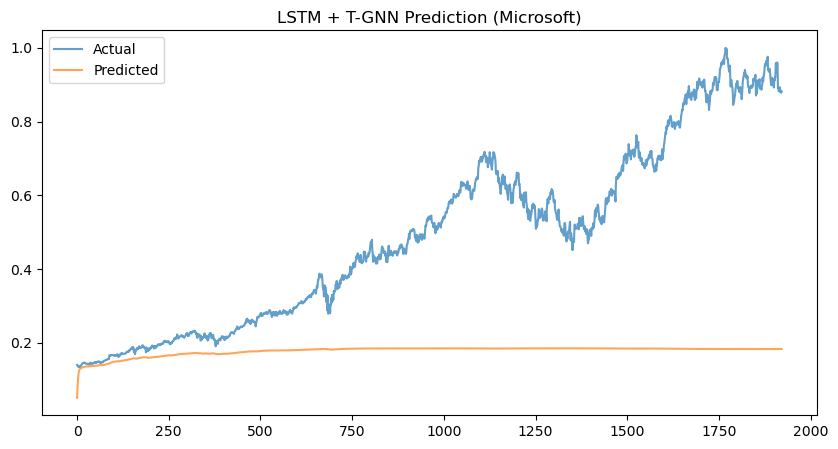

[I 2025-03-09 22:35:24,521] Trial 4 finished with value: 0.1544482260942459 and parameters: {'learning_rate': 0.004907551699707549, 'hidden_dim': 64, 'dropout_rate': 0.2867310627069382, 'epochs': 86, 'num_layers': 3}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/100, Loss: 0.000881
Epoch 20/100, Loss: 0.000687
Epoch 30/100, Loss: 0.000097
Epoch 40/100, Loss: 0.000012
Epoch 50/100, Loss: 0.000026
Epoch 60/100, Loss: 0.000018
Epoch 70/100, Loss: 0.000013
Epoch 80/100, Loss: 0.000010
Epoch 90/100, Loss: 0.000010
Epoch 100/100, Loss: 0.000010

Evaluation for Microsoft:
MSE: 0.008014
R2 Score: 0.865250


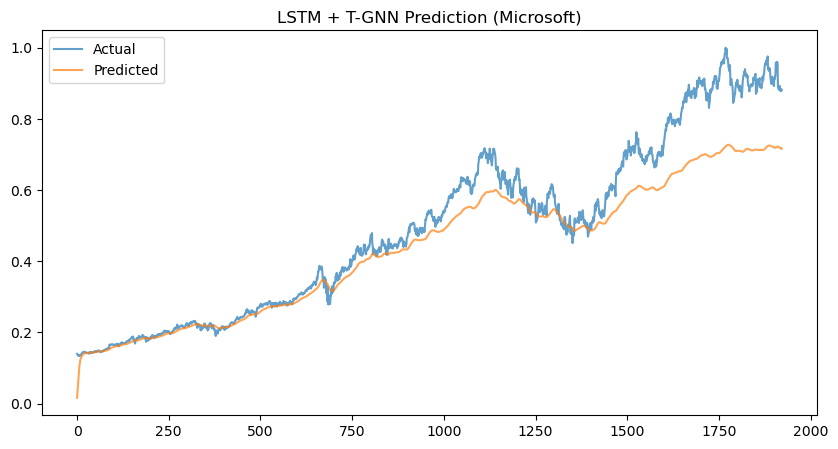

[I 2025-03-09 22:37:28,732] Trial 5 finished with value: 0.008013712242245674 and parameters: {'learning_rate': 0.00018606884195904852, 'hidden_dim': 256, 'dropout_rate': 0.18649362780189757, 'epochs': 100, 'num_layers': 3}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/52, Loss: 0.007136
Epoch 20/52, Loss: 0.004077
Epoch 30/52, Loss: 0.002134
Epoch 40/52, Loss: 0.001133
Epoch 50/52, Loss: 0.000777

Evaluation for Microsoft:
MSE: 0.233187
R2 Score: -2.921039


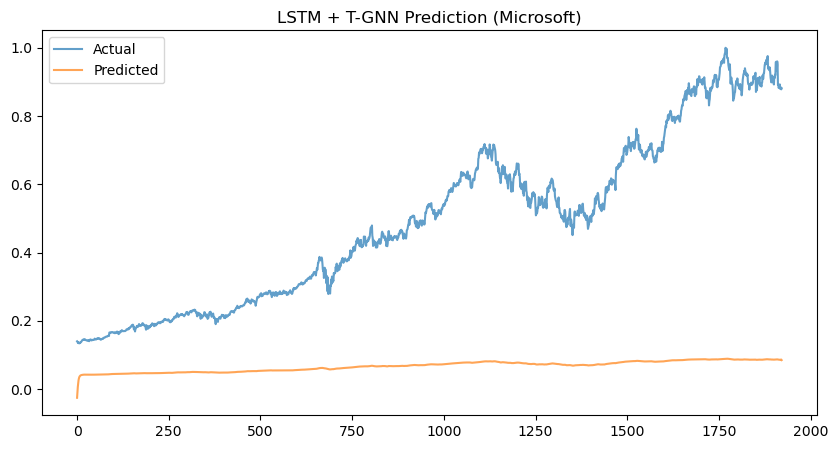

[I 2025-03-09 22:37:31,326] Trial 6 finished with value: 0.23318733274936676 and parameters: {'learning_rate': 0.00019629628036483724, 'hidden_dim': 32, 'dropout_rate': 0.28455998206305677, 'epochs': 52, 'num_layers': 1}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/94, Loss: 0.000612
Epoch 20/94, Loss: 0.000187
Epoch 30/94, Loss: 0.000072
Epoch 40/94, Loss: 0.000034
Epoch 50/94, Loss: 0.000018
Epoch 60/94, Loss: 0.000011
Epoch 70/94, Loss: 0.000009
Epoch 80/94, Loss: 0.000008
Epoch 90/94, Loss: 0.000008

Evaluation for Microsoft:
MSE: 0.012261
R2 Score: 0.793827


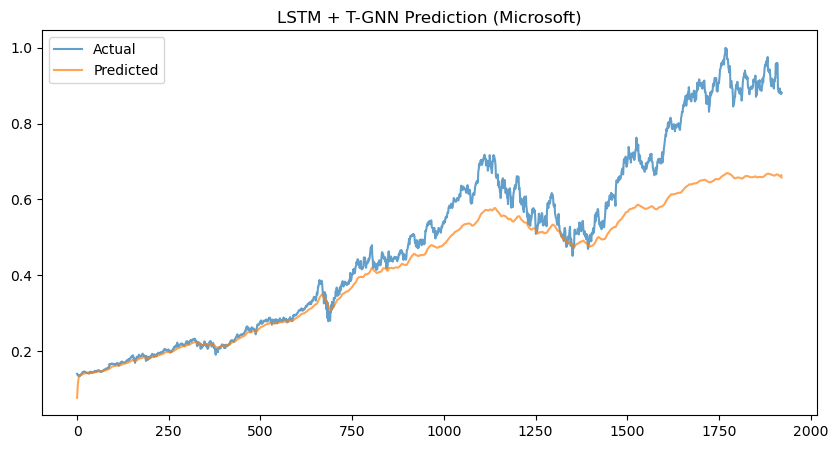

[I 2025-03-09 22:38:49,615] Trial 7 finished with value: 0.012261257506906986 and parameters: {'learning_rate': 0.0009558649485360645, 'hidden_dim': 256, 'dropout_rate': 0.24236152186797094, 'epochs': 94, 'num_layers': 2}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/67, Loss: 0.001278
Epoch 20/67, Loss: 0.000822
Epoch 30/67, Loss: 0.000191
Epoch 40/67, Loss: 0.000077
Epoch 50/67, Loss: 0.000028
Epoch 60/67, Loss: 0.000018

Evaluation for Microsoft:
MSE: 0.145242
R2 Score: -1.442246


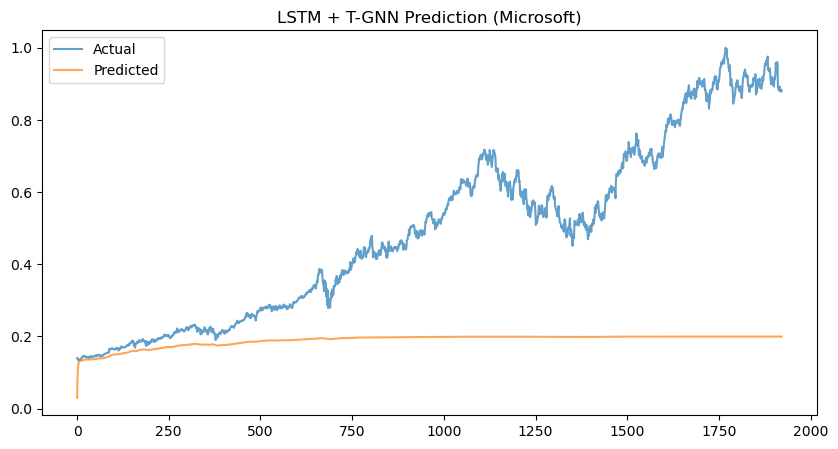

[I 2025-03-09 22:39:20,350] Trial 8 finished with value: 0.1452423334121704 and parameters: {'learning_rate': 0.004340718092430969, 'hidden_dim': 128, 'dropout_rate': 0.24419021359451515, 'epochs': 67, 'num_layers': 3}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/58, Loss: 0.000953
Epoch 20/58, Loss: 0.000490
Epoch 30/58, Loss: 0.000100
Epoch 40/58, Loss: 0.000030
Epoch 50/58, Loss: 0.000029

Evaluation for Microsoft:
MSE: 0.012655
R2 Score: 0.787213


[I 2025-03-09 22:40:12,625] Trial 9 finished with value: 0.012654617428779602 and parameters: {'learning_rate': 0.0004341638423511265, 'hidden_dim': 256, 'dropout_rate': 0.4555685917720106, 'epochs': 58, 'num_layers': 2}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/78, Loss: 0.000526
Epoch 20/78, Loss: 0.000164
Epoch 30/78, Loss: 0.000054
Epoch 40/78, Loss: 0.000023
Epoch 50/78, Loss: 0.000010
Epoch 60/78, Loss: 0.000005
Epoch 70/78, Loss: 0.000005

Evaluation for Microsoft:
MSE: 0.010069
R2 Score: 0.830694


[I 2025-03-09 22:40:18,436] Trial 10 finished with value: 0.01006876677274704 and parameters: {'learning_rate': 0.0018121638660005012, 'hidden_dim': 64, 'dropout_rate': 0.11795010247023882, 'epochs': 78, 'num_layers': 1}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/100, Loss: 0.001024
Epoch 20/100, Loss: 0.000894
Epoch 30/100, Loss: 0.000793
Epoch 40/100, Loss: 0.000600
Epoch 50/100, Loss: 0.000125
Epoch 60/100, Loss: 0.000061
Epoch 70/100, Loss: 0.000041
Epoch 80/100, Loss: 0.000015
Epoch 90/100, Loss: 0.000010
Epoch 100/100, Loss: 0.000010

Evaluation for Microsoft:
MSE: 0.017250
R2 Score: 0.709942


[I 2025-03-09 22:42:20,539] Trial 11 finished with value: 0.017249951139092445 and parameters: {'learning_rate': 0.00013141825886896073, 'hidden_dim': 256, 'dropout_rate': 0.17314948572326128, 'epochs': 100, 'num_layers': 3}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/85, Loss: 0.004307
Epoch 20/85, Loss: 0.000749
Epoch 30/85, Loss: 0.000702
Epoch 40/85, Loss: 0.000475
Epoch 50/85, Loss: 0.000301
Epoch 60/85, Loss: 0.000205
Epoch 70/85, Loss: 0.000110
Epoch 80/85, Loss: 0.000050

Evaluation for Microsoft:
MSE: 0.006531
R2 Score: 0.890176


[I 2025-03-09 22:42:56,298] Trial 12 finished with value: 0.0065313419327139854 and parameters: {'learning_rate': 0.00010134959295096325, 'hidden_dim': 256, 'dropout_rate': 0.18180147364199573, 'epochs': 85, 'num_layers': 1}. Best is trial 2 with value: 0.0024027074687182903.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/83, Loss: 0.000654
Epoch 20/83, Loss: 0.000377
Epoch 30/83, Loss: 0.000108
Epoch 40/83, Loss: 0.000010
Epoch 50/83, Loss: 0.000019
Epoch 60/83, Loss: 0.000005
Epoch 70/83, Loss: 0.000005
Epoch 80/83, Loss: 0.000004

Evaluation for Microsoft:
MSE: 0.001560
R2 Score: 0.973764


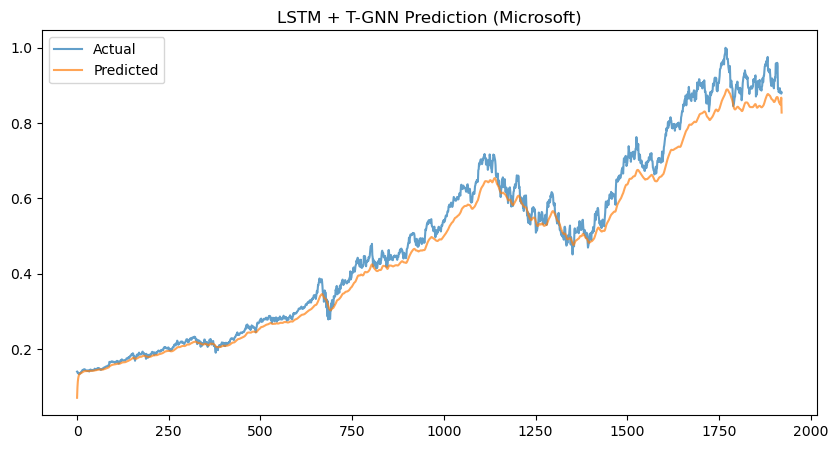

[I 2025-03-09 22:43:31,408] Trial 13 finished with value: 0.0015602495986968279 and parameters: {'learning_rate': 0.00010364803301922541, 'hidden_dim': 256, 'dropout_rate': 0.11255999071708125, 'epochs': 83, 'num_layers': 1}. Best is trial 13 with value: 0.0015602495986968279.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/75, Loss: 0.001623
Epoch 20/75, Loss: 0.000475
Epoch 30/75, Loss: 0.000079
Epoch 40/75, Loss: 0.000010
Epoch 50/75, Loss: 0.000017
Epoch 60/75, Loss: 0.000010
Epoch 70/75, Loss: 0.000008

Evaluation for Microsoft:
MSE: 0.001577
R2 Score: 0.973491


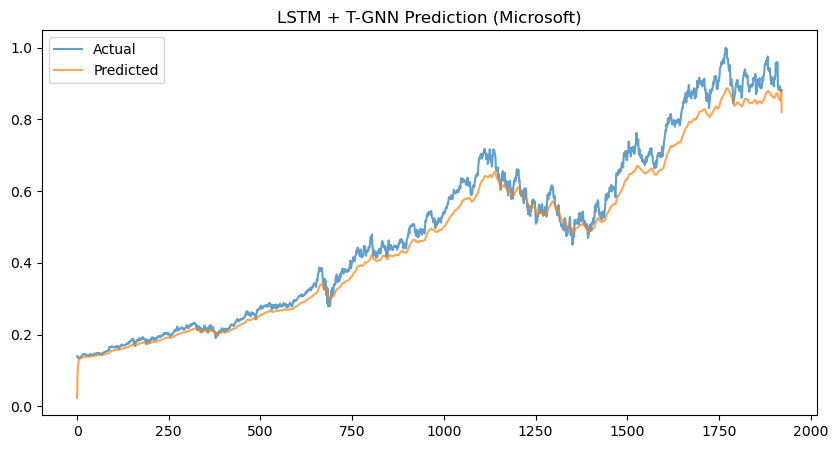

[I 2025-03-09 22:44:04,033] Trial 14 finished with value: 0.0015765242278575897 and parameters: {'learning_rate': 0.0003684928125544047, 'hidden_dim': 256, 'dropout_rate': 0.10558118095285186, 'epochs': 75, 'num_layers': 1}. Best is trial 13 with value: 0.0015602495986968279.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/73, Loss: 0.000331
Epoch 20/73, Loss: 0.000086
Epoch 30/73, Loss: 0.000013
Epoch 40/73, Loss: 0.000010
Epoch 50/73, Loss: 0.000007
Epoch 60/73, Loss: 0.000004
Epoch 70/73, Loss: 0.000003

Evaluation for Microsoft:
MSE: 0.000685
R2 Score: 0.988489


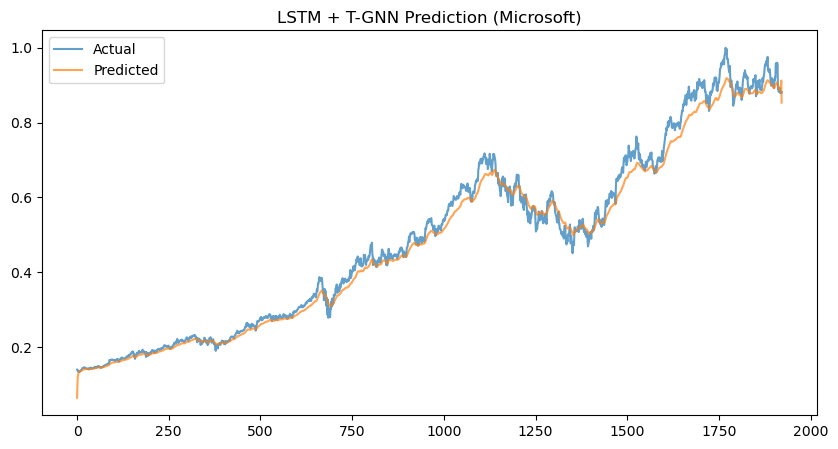

[I 2025-03-09 22:44:35,907] Trial 15 finished with value: 0.0006845714524388313 and parameters: {'learning_rate': 0.00044368010887017726, 'hidden_dim': 256, 'dropout_rate': 0.4059610199428074, 'epochs': 73, 'num_layers': 1}. Best is trial 15 with value: 0.0006845714524388313.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/73, Loss: 0.002174
Epoch 20/73, Loss: 0.000509
Epoch 30/73, Loss: 0.000490
Epoch 40/73, Loss: 0.000288
Epoch 50/73, Loss: 0.000080
Epoch 60/73, Loss: 0.000022
Epoch 70/73, Loss: 0.000016

Evaluation for Microsoft:
MSE: 0.003304
R2 Score: 0.944447


[I 2025-03-09 22:44:41,557] Trial 16 finished with value: 0.0033037846442312002 and parameters: {'learning_rate': 0.0014771580734090517, 'hidden_dim': 64, 'dropout_rate': 0.3912772970388194, 'epochs': 73, 'num_layers': 1}. Best is trial 15 with value: 0.0006845714524388313.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/82, Loss: 0.000850
Epoch 20/82, Loss: 0.001110
Epoch 30/82, Loss: 0.000448
Epoch 40/82, Loss: 0.000043
Epoch 50/82, Loss: 0.000030
Epoch 60/82, Loss: 0.000007
Epoch 70/82, Loss: 0.000004
Epoch 80/82, Loss: 0.000004

Evaluation for Microsoft:
MSE: 0.004295
R2 Score: 0.927780


[I 2025-03-09 22:44:55,984] Trial 17 finished with value: 0.004294972866773605 and parameters: {'learning_rate': 0.009614923550228504, 'hidden_dim': 128, 'dropout_rate': 0.3725348712574167, 'epochs': 82, 'num_layers': 1}. Best is trial 15 with value: 0.0006845714524388313.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/67, Loss: 0.001054
Epoch 20/67, Loss: 0.000906
Epoch 30/67, Loss: 0.000686
Epoch 40/67, Loss: 0.000538
Epoch 50/67, Loss: 0.000361
Epoch 60/67, Loss: 0.000203

Evaluation for Microsoft:
MSE: 0.069275
R2 Score: -0.164864


[I 2025-03-09 22:44:59,191] Trial 18 finished with value: 0.06927541643381119 and parameters: {'learning_rate': 0.0003844069979691846, 'hidden_dim': 32, 'dropout_rate': 0.36235098192654736, 'epochs': 67, 'num_layers': 1}. Best is trial 15 with value: 0.0006845714524388313.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/89, Loss: 0.000494
Epoch 20/89, Loss: 0.000108
Epoch 30/89, Loss: 0.000032
Epoch 40/89, Loss: 0.000018
Epoch 50/89, Loss: 0.000008
Epoch 60/89, Loss: 0.000004
Epoch 70/89, Loss: 0.000004
Epoch 80/89, Loss: 0.000003

Evaluation for Microsoft:
MSE: 0.000496
R2 Score: 0.991653


[I 2025-03-09 22:45:35,548] Trial 19 finished with value: 0.0004963846877217293 and parameters: {'learning_rate': 0.0006487948090821411, 'hidden_dim': 256, 'dropout_rate': 0.42049840034390173, 'epochs': 89, 'num_layers': 1}. Best is trial 19 with value: 0.0004963846877217293.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/92, Loss: 0.000420
Epoch 20/92, Loss: 0.000149
Epoch 30/92, Loss: 0.000023
Epoch 40/92, Loss: 0.000022
Epoch 50/92, Loss: 0.000007
Epoch 60/92, Loss: 0.000006
Epoch 70/92, Loss: 0.000003
Epoch 80/92, Loss: 0.000003
Epoch 90/92, Loss: 0.000003

Evaluation for Microsoft:
MSE: 0.000960
R2 Score: 0.983852


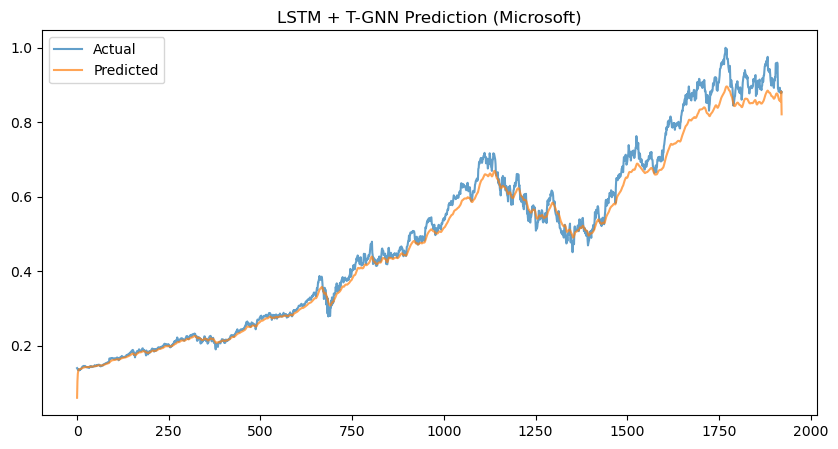

[I 2025-03-09 22:46:13,409] Trial 20 finished with value: 0.0009603543439880013 and parameters: {'learning_rate': 0.0006200906731136046, 'hidden_dim': 256, 'dropout_rate': 0.49943559728302767, 'epochs': 92, 'num_layers': 1}. Best is trial 19 with value: 0.0004963846877217293.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/90, Loss: 0.000478
Epoch 20/90, Loss: 0.000118
Epoch 30/90, Loss: 0.000031
Epoch 40/90, Loss: 0.000019
Epoch 50/90, Loss: 0.000007
Epoch 60/90, Loss: 0.000005
Epoch 70/90, Loss: 0.000004
Epoch 80/90, Loss: 0.000003
Epoch 90/90, Loss: 0.000003

Evaluation for Microsoft:
MSE: 0.000717
R2 Score: 0.987950


[I 2025-03-09 22:46:52,268] Trial 21 finished with value: 0.0007165948627516627 and parameters: {'learning_rate': 0.0006531166352568504, 'hidden_dim': 256, 'dropout_rate': 0.48493540130323853, 'epochs': 90, 'num_layers': 1}. Best is trial 19 with value: 0.0004963846877217293.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/90, Loss: 0.000220
Epoch 20/90, Loss: 0.000107
Epoch 30/90, Loss: 0.000036
Epoch 40/90, Loss: 0.000013
Epoch 50/90, Loss: 0.000007
Epoch 60/90, Loss: 0.000004
Epoch 70/90, Loss: 0.000003
Epoch 80/90, Loss: 0.000003
Epoch 90/90, Loss: 0.000002

Evaluation for Microsoft:
MSE: 0.007425
R2 Score: 0.875155


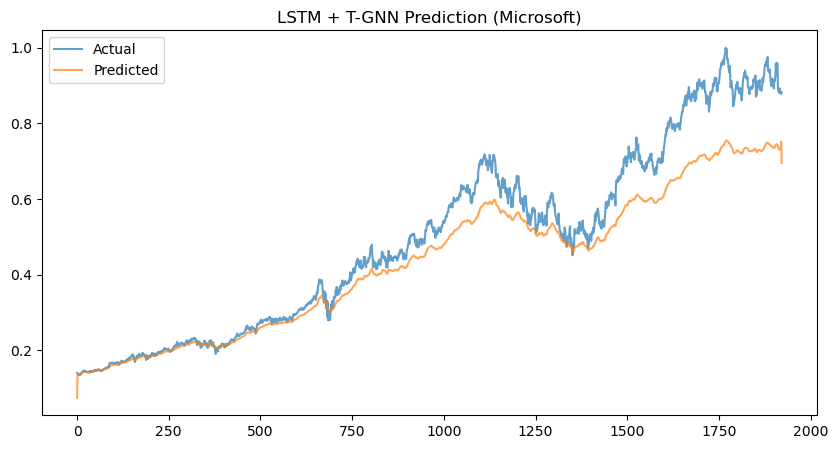

[I 2025-03-09 22:47:31,277] Trial 22 finished with value: 0.007424627430737019 and parameters: {'learning_rate': 0.0017637478184211403, 'hidden_dim': 256, 'dropout_rate': 0.4901900272636275, 'epochs': 90, 'num_layers': 1}. Best is trial 19 with value: 0.0004963846877217293.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/89, Loss: 0.000315
Epoch 20/89, Loss: 0.000142
Epoch 30/89, Loss: 0.000027
Epoch 40/89, Loss: 0.000010
Epoch 50/89, Loss: 0.000009
Epoch 60/89, Loss: 0.000006
Epoch 70/89, Loss: 0.000004
Epoch 80/89, Loss: 0.000004

Evaluation for Microsoft:
MSE: 0.002150
R2 Score: 0.963849


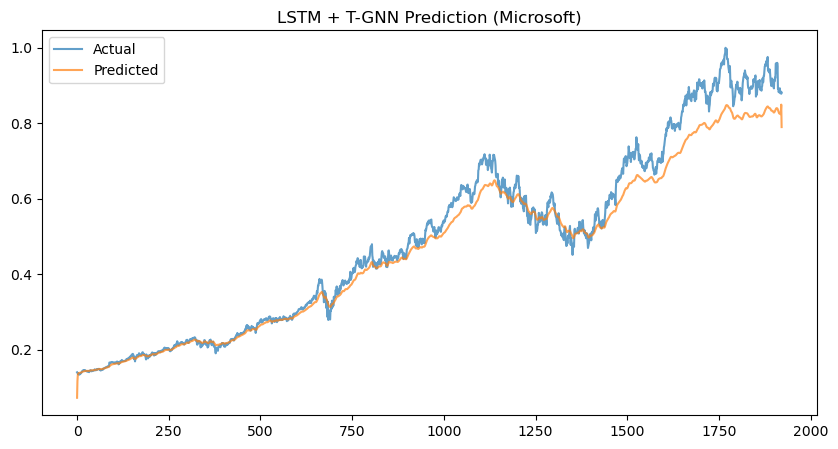

[I 2025-03-09 22:48:09,551] Trial 23 finished with value: 0.002149903913959861 and parameters: {'learning_rate': 0.0010334656857010024, 'hidden_dim': 256, 'dropout_rate': 0.4240143204955974, 'epochs': 89, 'num_layers': 1}. Best is trial 19 with value: 0.0004963846877217293.



=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/78, Loss: 0.001091
Epoch 20/78, Loss: 0.000503
Epoch 30/78, Loss: 0.000150
Epoch 40/78, Loss: 0.000047
Epoch 50/78, Loss: 0.000027
Epoch 60/78, Loss: 0.000023
Epoch 70/78, Loss: 0.000018

Evaluation for Microsoft:
MSE: 0.021578
R2 Score: 0.637166


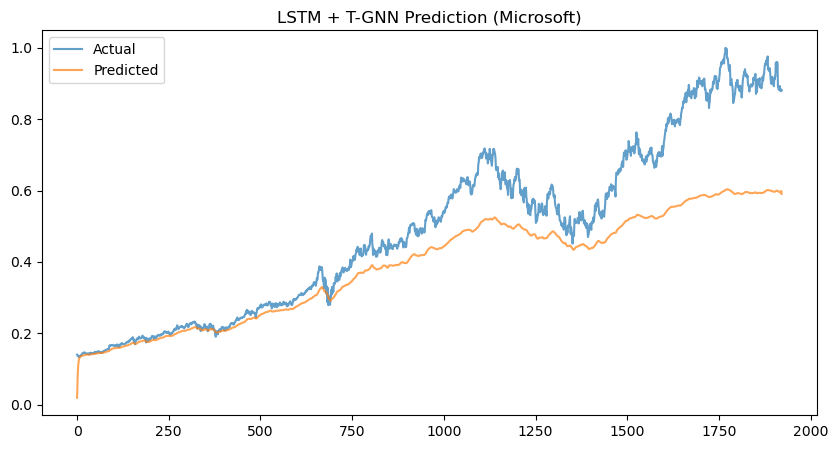

[I 2025-03-09 22:49:13,137] Trial 24 finished with value: 0.021578015759587288 and parameters: {'learning_rate': 0.0005889768312593164, 'hidden_dim': 256, 'dropout_rate': 0.4608364060225213, 'epochs': 78, 'num_layers': 2}. Best is trial 19 with value: 0.0004963846877217293.
[I 2025-03-09 22:49:13,138] A new study created in memory with name: no-name-78051194-75de-4b89-beed-53d6a4357b6d


Best parameters for Microsoft: {'learning_rate': 0.0006487948090821411, 'hidden_dim': 256, 'dropout_rate': 0.42049840034390173, 'epochs': 89, 'num_layers': 1}

=== Training LSTM + T-GNN for Apple ===
Epoch 10/99, Loss: 0.001277
Epoch 20/99, Loss: 0.000566
Epoch 30/99, Loss: 0.000173
Epoch 40/99, Loss: 0.000073
Epoch 50/99, Loss: 0.000036
Epoch 60/99, Loss: 0.000023
Epoch 70/99, Loss: 0.000018
Epoch 80/99, Loss: 0.000016
Epoch 90/99, Loss: 0.000014

Evaluation for Apple:
MSE: 0.114409
R2 Score: -0.789699


[I 2025-03-09 22:51:26,195] Trial 0 finished with value: 0.11440879106521606 and parameters: {'learning_rate': 0.002848565242546304, 'hidden_dim': 256, 'dropout_rate': 0.4614742593569311, 'epochs': 99, 'num_layers': 3}. Best is trial 0 with value: 0.11440879106521606.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/89, Loss: 0.000972
Epoch 20/89, Loss: 0.000577
Epoch 30/89, Loss: 0.000434
Epoch 40/89, Loss: 0.000287
Epoch 50/89, Loss: 0.000107
Epoch 60/89, Loss: 0.000008
Epoch 70/89, Loss: 0.000016
Epoch 80/89, Loss: 0.000003

Evaluation for Apple:
MSE: 0.003733
R2 Score: 0.941602


[I 2025-03-09 22:51:30,822] Trial 1 finished with value: 0.0037331453058868647 and parameters: {'learning_rate': 0.0009642316762143746, 'hidden_dim': 32, 'dropout_rate': 0.2460059168492149, 'epochs': 89, 'num_layers': 1}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/90, Loss: 0.000880
Epoch 20/90, Loss: 0.000182
Epoch 30/90, Loss: 0.000055
Epoch 40/90, Loss: 0.000017
Epoch 50/90, Loss: 0.000007
Epoch 60/90, Loss: 0.000004
Epoch 70/90, Loss: 0.000002
Epoch 80/90, Loss: 0.000002
Epoch 90/90, Loss: 0.000002

Evaluation for Apple:
MSE: 0.085932
R2 Score: -0.344238


[I 2025-03-09 22:51:48,386] Trial 2 finished with value: 0.08593215048313141 and parameters: {'learning_rate': 0.004149219193794637, 'hidden_dim': 128, 'dropout_rate': 0.2785041417481101, 'epochs': 90, 'num_layers': 1}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/71, Loss: 0.000675
Epoch 20/71, Loss: 0.000925
Epoch 30/71, Loss: 0.000260
Epoch 40/71, Loss: 0.000092
Epoch 50/71, Loss: 0.000029
Epoch 60/71, Loss: 0.000016
Epoch 70/71, Loss: 0.000011

Evaluation for Apple:
MSE: 0.149147
R2 Score: -1.333117


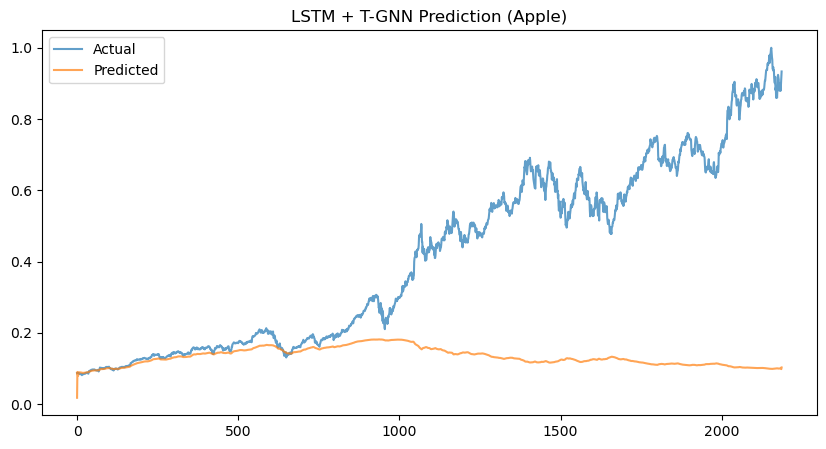

[I 2025-03-09 22:52:13,402] Trial 3 finished with value: 0.14914749562740326 and parameters: {'learning_rate': 0.006900832486246356, 'hidden_dim': 128, 'dropout_rate': 0.12415301299932704, 'epochs': 71, 'num_layers': 2}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/91, Loss: 0.000774
Epoch 20/91, Loss: 0.000845
Epoch 30/91, Loss: 0.000760
Epoch 40/91, Loss: 0.000629
Epoch 50/91, Loss: 0.000576
Epoch 60/91, Loss: 0.000430
Epoch 70/91, Loss: 0.000188
Epoch 80/91, Loss: 0.000024
Epoch 90/91, Loss: 0.000020

Evaluation for Apple:
MSE: 0.096545
R2 Score: -0.510252


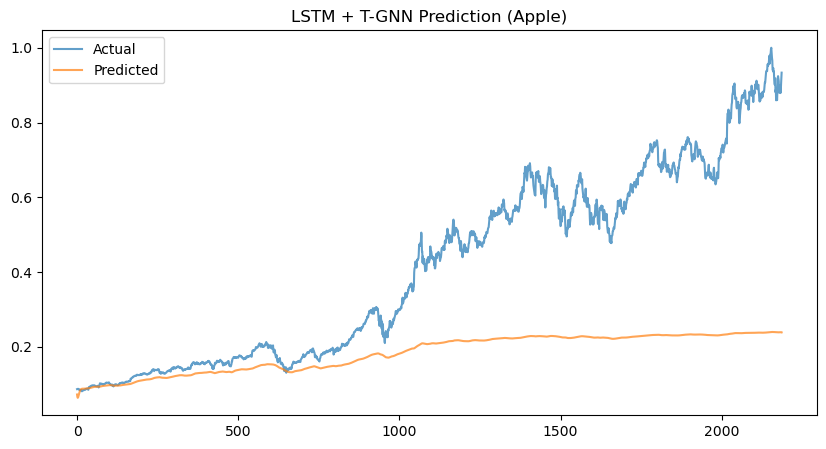

[I 2025-03-09 22:52:34,509] Trial 4 finished with value: 0.0965447947382927 and parameters: {'learning_rate': 0.00034840808801307, 'hidden_dim': 64, 'dropout_rate': 0.12111427534335327, 'epochs': 91, 'num_layers': 3}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/91, Loss: 0.001443
Epoch 20/91, Loss: 0.000790
Epoch 30/91, Loss: 0.000913
Epoch 40/91, Loss: 0.000356
Epoch 50/91, Loss: 0.000115
Epoch 60/91, Loss: 0.000036
Epoch 70/91, Loss: 0.000028
Epoch 80/91, Loss: 0.000012
Epoch 90/91, Loss: 0.000009

Evaluation for Apple:
MSE: 0.032198
R2 Score: 0.496319


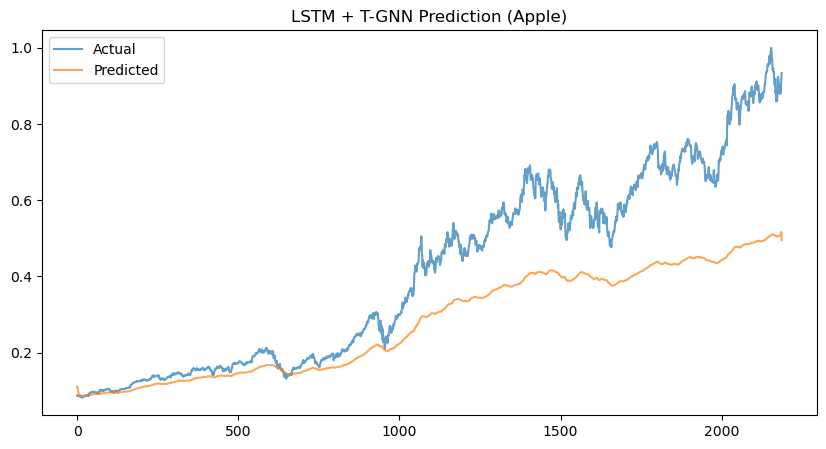

[I 2025-03-09 22:52:39,284] Trial 5 finished with value: 0.0321984738111496 and parameters: {'learning_rate': 0.0018297343779198846, 'hidden_dim': 32, 'dropout_rate': 0.20487168841471984, 'epochs': 91, 'num_layers': 1}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/92, Loss: 0.000988
Epoch 20/92, Loss: 0.000701
Epoch 30/92, Loss: 0.000618
Epoch 40/92, Loss: 0.000093
Epoch 50/92, Loss: 0.000060
Epoch 60/92, Loss: 0.000039
Epoch 70/92, Loss: 0.000026
Epoch 80/92, Loss: 0.000019
Epoch 90/92, Loss: 0.000016

Evaluation for Apple:
MSE: 0.143178
R2 Score: -1.239743


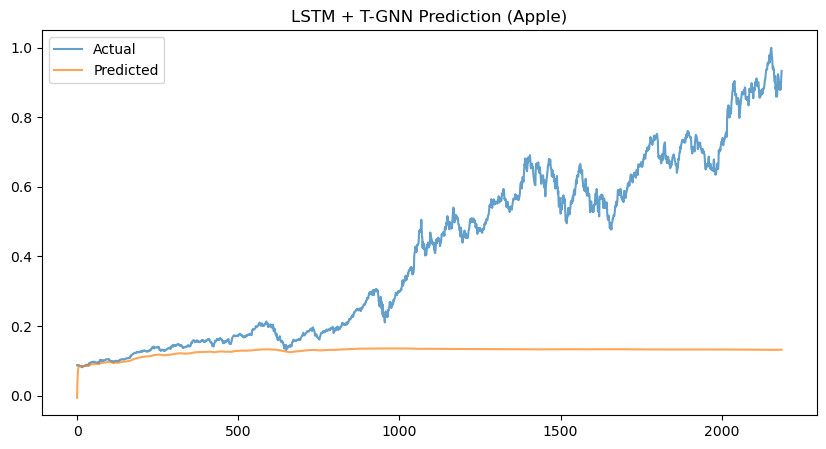

[I 2025-03-09 22:52:53,071] Trial 6 finished with value: 0.14317843317985535 and parameters: {'learning_rate': 0.009533486318073813, 'hidden_dim': 32, 'dropout_rate': 0.16183658592872835, 'epochs': 92, 'num_layers': 3}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/92, Loss: 0.000925
Epoch 20/92, Loss: 0.000752
Epoch 30/92, Loss: 0.000687
Epoch 40/92, Loss: 0.000644
Epoch 50/92, Loss: 0.000572
Epoch 60/92, Loss: 0.000389
Epoch 70/92, Loss: 0.000050
Epoch 80/92, Loss: 0.000037
Epoch 90/92, Loss: 0.000035

Evaluation for Apple:
MSE: 0.072121
R2 Score: -0.128183


[I 2025-03-09 22:53:14,740] Trial 7 finished with value: 0.0721205547451973 and parameters: {'learning_rate': 0.00029256840155279313, 'hidden_dim': 64, 'dropout_rate': 0.21260341065397223, 'epochs': 92, 'num_layers': 3}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/65, Loss: 0.019112
Epoch 20/65, Loss: 0.013428
Epoch 30/65, Loss: 0.008761
Epoch 40/65, Loss: 0.005118
Epoch 50/65, Loss: 0.002627
Epoch 60/65, Loss: 0.001275

Evaluation for Apple:
MSE: 0.210471
R2 Score: -2.292408


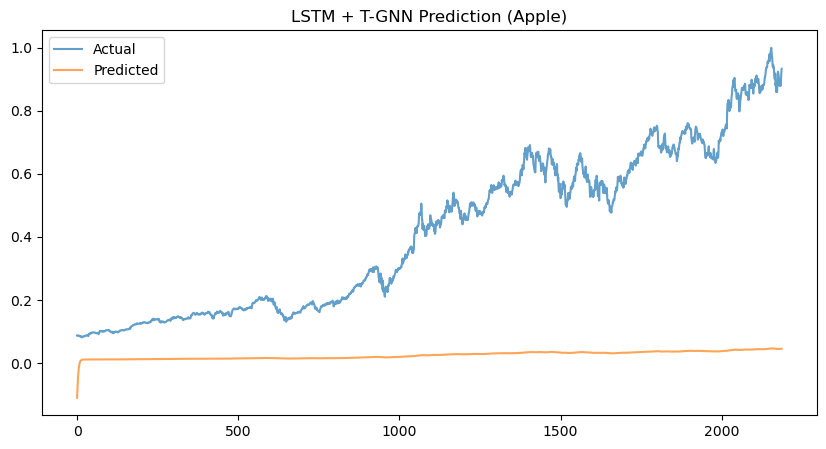

[I 2025-03-09 22:53:24,320] Trial 8 finished with value: 0.21047134697437286 and parameters: {'learning_rate': 0.00013939270064435125, 'hidden_dim': 32, 'dropout_rate': 0.46257609187129745, 'epochs': 65, 'num_layers': 3}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/56, Loss: 0.000759
Epoch 20/56, Loss: 0.000049
Epoch 30/56, Loss: 0.000081
Epoch 40/56, Loss: 0.000031
Epoch 50/56, Loss: 0.000014

Evaluation for Apple:
MSE: 0.112827
R2 Score: -0.764953


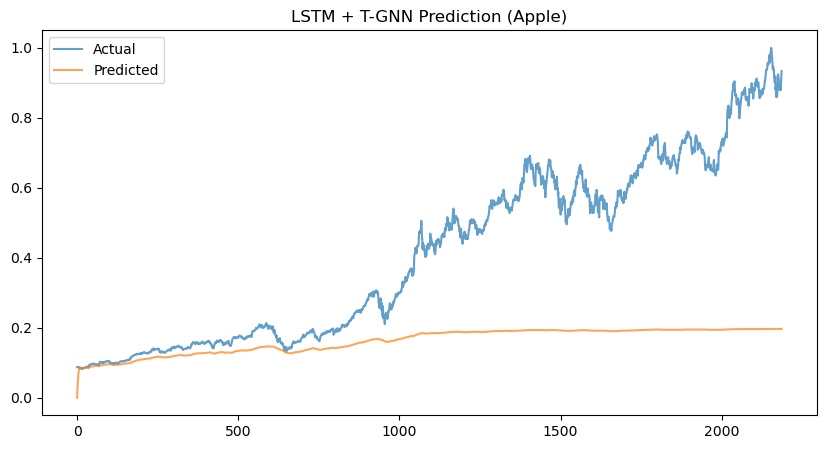

[I 2025-03-09 22:54:35,760] Trial 9 finished with value: 0.1128268614411354 and parameters: {'learning_rate': 0.001171776251558906, 'hidden_dim': 256, 'dropout_rate': 0.3013907408914642, 'epochs': 56, 'num_layers': 3}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/77, Loss: 0.000739
Epoch 20/77, Loss: 0.000680
Epoch 30/77, Loss: 0.000588
Epoch 40/77, Loss: 0.000423
Epoch 50/77, Loss: 0.000121
Epoch 60/77, Loss: 0.000104
Epoch 70/77, Loss: 0.000064

Evaluation for Apple:
MSE: 0.045669
R2 Score: 0.285600


[I 2025-03-09 22:54:43,671] Trial 10 finished with value: 0.045668940991163254 and parameters: {'learning_rate': 0.0005599532953704874, 'hidden_dim': 32, 'dropout_rate': 0.356580554895026, 'epochs': 77, 'num_layers': 2}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/82, Loss: 0.000434
Epoch 20/82, Loss: 0.000168
Epoch 30/82, Loss: 0.000048
Epoch 40/82, Loss: 0.000026
Epoch 50/82, Loss: 0.000014
Epoch 60/82, Loss: 0.000008
Epoch 70/82, Loss: 0.000007
Epoch 80/82, Loss: 0.000006

Evaluation for Apple:
MSE: 0.030661
R2 Score: 0.520372


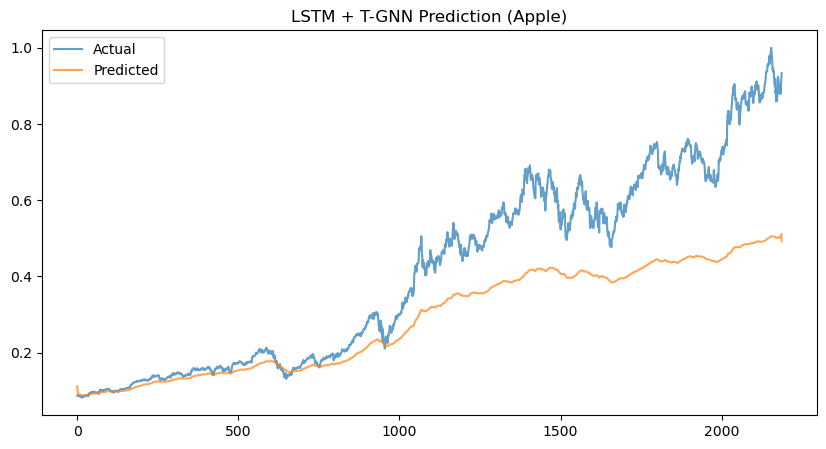

[I 2025-03-09 22:54:48,042] Trial 11 finished with value: 0.030660826712846756 and parameters: {'learning_rate': 0.0015882603472917758, 'hidden_dim': 32, 'dropout_rate': 0.2210468118932473, 'epochs': 82, 'num_layers': 1}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/79, Loss: 0.000710
Epoch 20/79, Loss: 0.000385
Epoch 30/79, Loss: 0.000205
Epoch 40/79, Loss: 0.000047
Epoch 50/79, Loss: 0.000019
Epoch 60/79, Loss: 0.000012
Epoch 70/79, Loss: 0.000005

Evaluation for Apple:
MSE: 0.023188
R2 Score: 0.637274


[I 2025-03-09 22:54:52,163] Trial 12 finished with value: 0.023187709972262383 and parameters: {'learning_rate': 0.0008700421452846845, 'hidden_dim': 32, 'dropout_rate': 0.267492493793141, 'epochs': 79, 'num_layers': 1}. Best is trial 1 with value: 0.0037331453058868647.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/81, Loss: 0.001603
Epoch 20/81, Loss: 0.000822
Epoch 30/81, Loss: 0.000552
Epoch 40/81, Loss: 0.000354
Epoch 50/81, Loss: 0.000206
Epoch 60/81, Loss: 0.000094
Epoch 70/81, Loss: 0.000018
Epoch 80/81, Loss: 0.000007

Evaluation for Apple:
MSE: 0.002084
R2 Score: 0.967405


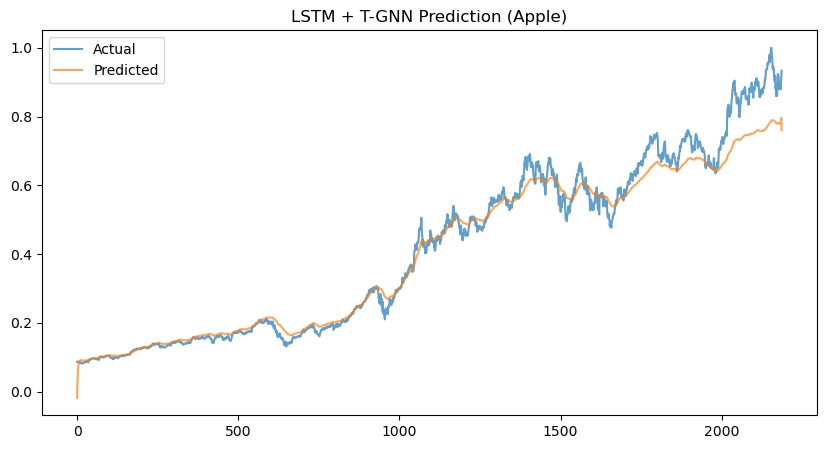

[I 2025-03-09 22:54:56,551] Trial 13 finished with value: 0.002083648694679141 and parameters: {'learning_rate': 0.000710356036392514, 'hidden_dim': 32, 'dropout_rate': 0.36173855518598275, 'epochs': 81, 'num_layers': 1}. Best is trial 13 with value: 0.002083648694679141.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/84, Loss: 0.002594
Epoch 20/84, Loss: 0.000807
Epoch 30/84, Loss: 0.000935
Epoch 40/84, Loss: 0.000625
Epoch 50/84, Loss: 0.000600
Epoch 60/84, Loss: 0.000496
Epoch 70/84, Loss: 0.000396
Epoch 80/84, Loss: 0.000258

Evaluation for Apple:
MSE: 0.074507
R2 Score: -0.165514


[I 2025-03-09 22:55:05,142] Trial 14 finished with value: 0.0745069682598114 and parameters: {'learning_rate': 0.0005234090586749766, 'hidden_dim': 32, 'dropout_rate': 0.3727897021337824, 'epochs': 84, 'num_layers': 2}. Best is trial 13 with value: 0.002083648694679141.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/70, Loss: 0.003751
Epoch 20/70, Loss: 0.002673
Epoch 30/70, Loss: 0.001863
Epoch 40/70, Loss: 0.001292
Epoch 50/70, Loss: 0.000917
Epoch 60/70, Loss: 0.000691
Epoch 70/70, Loss: 0.000565

Evaluation for Apple:
MSE: 0.159106
R2 Score: -1.488905


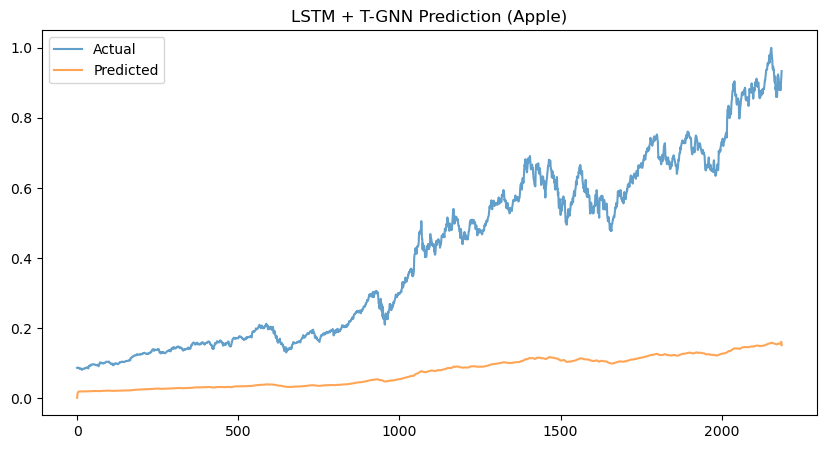

[I 2025-03-09 22:55:08,849] Trial 15 finished with value: 0.15910641849040985 and parameters: {'learning_rate': 0.00010067977863212578, 'hidden_dim': 32, 'dropout_rate': 0.3855456140069527, 'epochs': 70, 'num_layers': 1}. Best is trial 13 with value: 0.002083648694679141.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/85, Loss: 0.000061
Epoch 20/85, Loss: 0.000025
Epoch 30/85, Loss: 0.000008
Epoch 40/85, Loss: 0.000003
Epoch 50/85, Loss: 0.000003
Epoch 60/85, Loss: 0.000002
Epoch 70/85, Loss: 0.000002
Epoch 80/85, Loss: 0.000002

Evaluation for Apple:
MSE: 0.002988
R2 Score: 0.953259


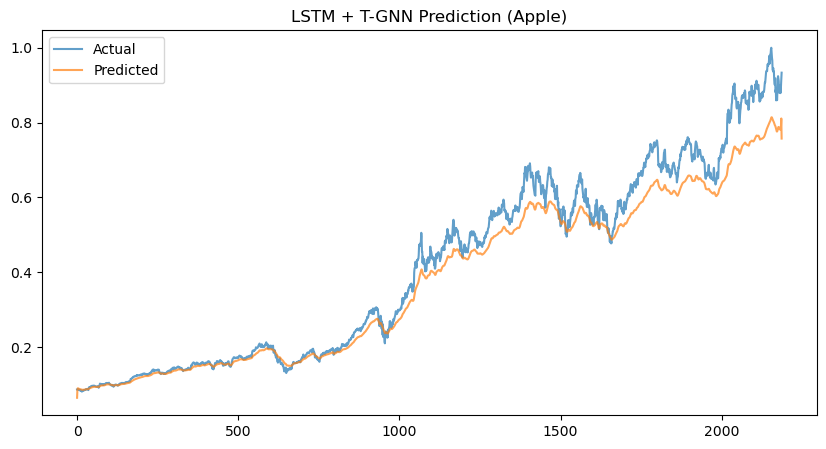

[I 2025-03-09 22:55:47,547] Trial 16 finished with value: 0.0029879806097596884 and parameters: {'learning_rate': 0.0007296222414443084, 'hidden_dim': 256, 'dropout_rate': 0.3274922579843592, 'epochs': 85, 'num_layers': 1}. Best is trial 13 with value: 0.002083648694679141.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/99, Loss: 0.000582
Epoch 20/99, Loss: 0.000181
Epoch 30/99, Loss: 0.000070
Epoch 40/99, Loss: 0.000031
Epoch 50/99, Loss: 0.000012
Epoch 60/99, Loss: 0.000010
Epoch 70/99, Loss: 0.000010
Epoch 80/99, Loss: 0.000010
Epoch 90/99, Loss: 0.000009

Evaluation for Apple:
MSE: 0.006265
R2 Score: 0.902000


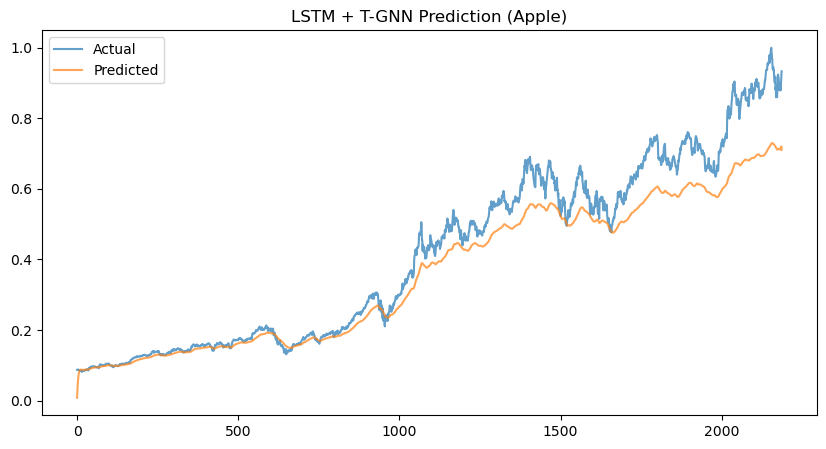

[I 2025-03-09 22:57:11,569] Trial 17 finished with value: 0.006264800671488047 and parameters: {'learning_rate': 0.00028018035296312026, 'hidden_dim': 256, 'dropout_rate': 0.3395234701376372, 'epochs': 99, 'num_layers': 2}. Best is trial 13 with value: 0.002083648694679141.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/52, Loss: 0.000242
Epoch 20/52, Loss: 0.000154
Epoch 30/52, Loss: 0.000019
Epoch 40/52, Loss: 0.000011
Epoch 50/52, Loss: 0.000010

Evaluation for Apple:
MSE: 0.000596
R2 Score: 0.990681


[I 2025-03-09 22:57:35,524] Trial 18 finished with value: 0.0005957501707598567 and parameters: {'learning_rate': 0.0005846066672091906, 'hidden_dim': 256, 'dropout_rate': 0.41194448127983113, 'epochs': 52, 'num_layers': 1}. Best is trial 18 with value: 0.0005957501707598567.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/56, Loss: 0.000627
Epoch 20/56, Loss: 0.000052
Epoch 30/56, Loss: 0.000019
Epoch 40/56, Loss: 0.000022
Epoch 50/56, Loss: 0.000016

Evaluation for Apple:
MSE: 0.020264
R2 Score: 0.683017


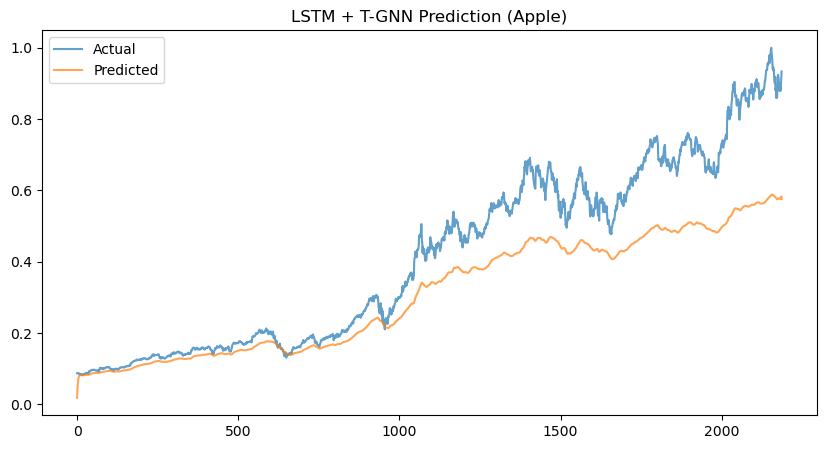

[I 2025-03-09 22:58:25,870] Trial 19 finished with value: 0.02026355266571045 and parameters: {'learning_rate': 0.0004045783522040482, 'hidden_dim': 256, 'dropout_rate': 0.4237328962340284, 'epochs': 56, 'num_layers': 2}. Best is trial 18 with value: 0.0005957501707598567.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/52, Loss: 0.005934
Epoch 20/52, Loss: 0.003046
Epoch 30/52, Loss: 0.001260
Epoch 40/52, Loss: 0.000451
Epoch 50/52, Loss: 0.000313

Evaluation for Apple:
MSE: 0.070195
R2 Score: -0.098062


[I 2025-03-09 22:58:30,498] Trial 20 finished with value: 0.0701950341463089 and parameters: {'learning_rate': 0.0001920511135548885, 'hidden_dim': 64, 'dropout_rate': 0.4189682804530495, 'epochs': 52, 'num_layers': 1}. Best is trial 18 with value: 0.0005957501707598567.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/66, Loss: 0.000293
Epoch 20/66, Loss: 0.000106
Epoch 30/66, Loss: 0.000017
Epoch 40/66, Loss: 0.000010
Epoch 50/66, Loss: 0.000008
Epoch 60/66, Loss: 0.000003

Evaluation for Apple:
MSE: 0.001549
R2 Score: 0.975762


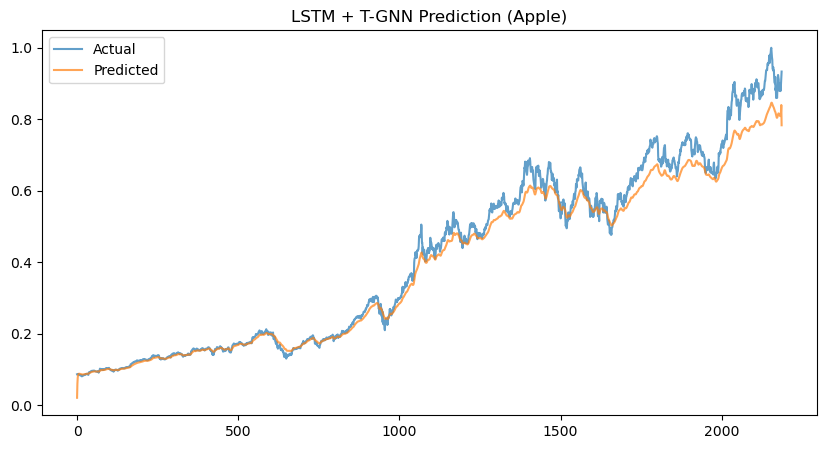

[I 2025-03-09 22:59:00,602] Trial 21 finished with value: 0.0015494361286982894 and parameters: {'learning_rate': 0.0007211438779882907, 'hidden_dim': 256, 'dropout_rate': 0.3286595337817849, 'epochs': 66, 'num_layers': 1}. Best is trial 18 with value: 0.0005957501707598567.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/65, Loss: 0.000455
Epoch 20/65, Loss: 0.000083
Epoch 30/65, Loss: 0.000035
Epoch 40/65, Loss: 0.000014
Epoch 50/65, Loss: 0.000005
Epoch 60/65, Loss: 0.000003

Evaluation for Apple:
MSE: 0.015422
R2 Score: 0.758750


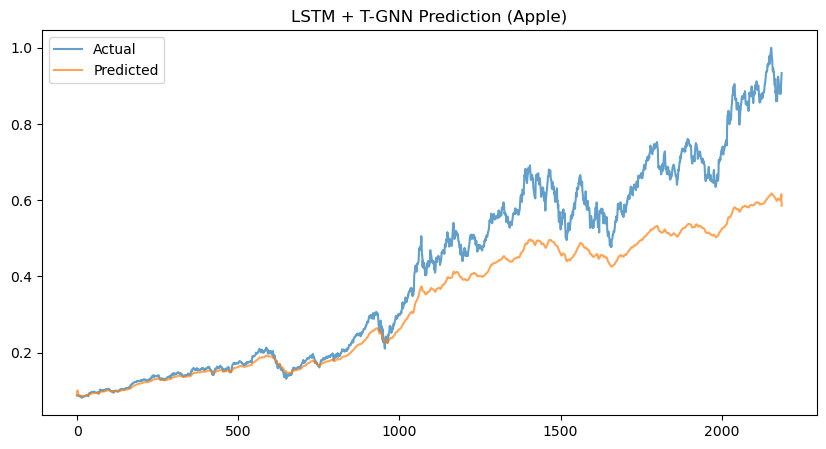

[I 2025-03-09 22:59:30,898] Trial 22 finished with value: 0.015422205440700054 and parameters: {'learning_rate': 0.0014328165085976505, 'hidden_dim': 256, 'dropout_rate': 0.4118901670128333, 'epochs': 65, 'num_layers': 1}. Best is trial 18 with value: 0.0005957501707598567.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/63, Loss: 0.000294
Epoch 20/63, Loss: 0.000055
Epoch 30/63, Loss: 0.000032
Epoch 40/63, Loss: 0.000007
Epoch 50/63, Loss: 0.000003
Epoch 60/63, Loss: 0.000003

Evaluation for Apple:
MSE: 0.001421
R2 Score: 0.977770


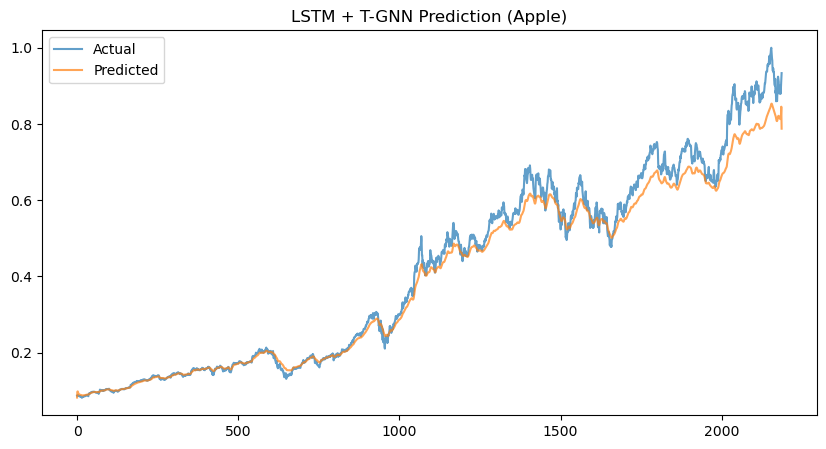

[I 2025-03-09 23:00:01,295] Trial 23 finished with value: 0.0014210946392267942 and parameters: {'learning_rate': 0.000629477325773089, 'hidden_dim': 256, 'dropout_rate': 0.48537882394637716, 'epochs': 63, 'num_layers': 1}. Best is trial 18 with value: 0.0005957501707598567.



=== Training LSTM + T-GNN for Apple ===
Epoch 10/61, Loss: 0.001131
Epoch 20/61, Loss: 0.000171
Epoch 30/61, Loss: 0.000070
Epoch 40/61, Loss: 0.000013
Epoch 50/61, Loss: 0.000015
Epoch 60/61, Loss: 0.000013

Evaluation for Apple:
MSE: 0.103433
R2 Score: -0.617998


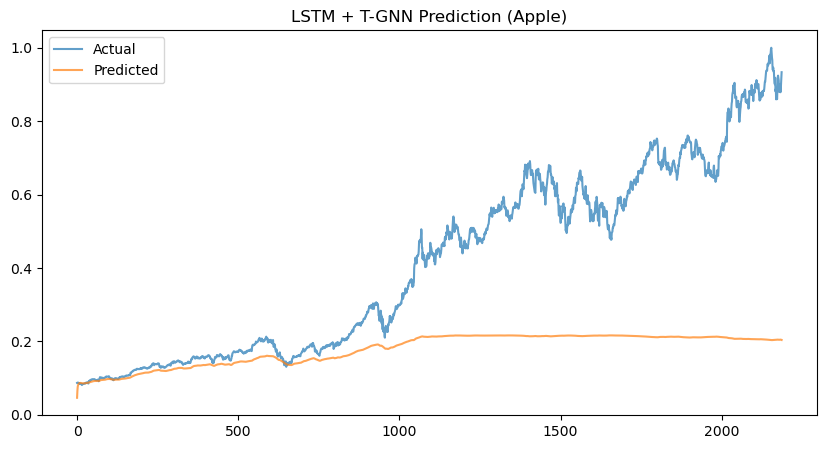

[I 2025-03-09 23:00:57,889] Trial 24 finished with value: 0.10343258827924728 and parameters: {'learning_rate': 0.0024550153528641147, 'hidden_dim': 256, 'dropout_rate': 0.4999730097357582, 'epochs': 61, 'num_layers': 2}. Best is trial 18 with value: 0.0005957501707598567.


Best parameters for Apple: {'learning_rate': 0.0005846066672091906, 'hidden_dim': 256, 'dropout_rate': 0.41194448127983113, 'epochs': 52, 'num_layers': 1}


In [11]:
def objective(trial, stock):
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    epochs = trial.suggest_int("epochs", 50, 100)
    num_layers = trial.suggest_int("num_layers", 1, 3)

    results = train_lstm_tgnn(stock, hidden_dim, num_layers, dropout_rate, epochs, learning_rate, plot=False)
    return results["MSE"]  

def optimize_lstm_tgnn(stock):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, stock), n_trials=25)

    print(f"Best parameters for {stock}: {study.best_params}")
    return study.best_params

optimized_params = {stock: optimize_lstm_tgnn(stock) for stock in file_paths}


=== Training LSTM + T-GNN for NVIDIA ===
Epoch 10/55, Loss: 0.000126
Epoch 20/55, Loss: 0.000025
Epoch 30/55, Loss: 0.000005
Epoch 40/55, Loss: 0.000003
Epoch 50/55, Loss: 0.000002

Evaluation for NVIDIA:
MSE: 0.002347
R2 Score: 0.967926


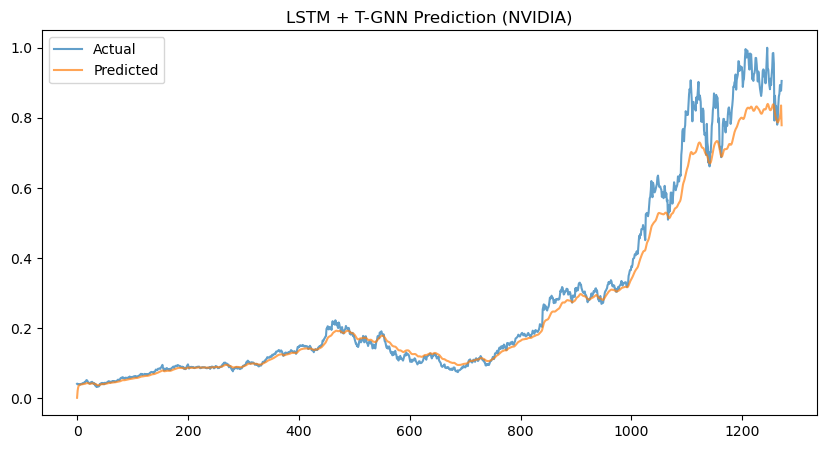


=== Training LSTM + T-GNN for Microsoft ===
Epoch 10/89, Loss: 0.000337
Epoch 20/89, Loss: 0.000070
Epoch 30/89, Loss: 0.000056
Epoch 40/89, Loss: 0.000041
Epoch 50/89, Loss: 0.000014
Epoch 60/89, Loss: 0.000005
Epoch 70/89, Loss: 0.000005
Epoch 80/89, Loss: 0.000004

Evaluation for Microsoft:
MSE: 0.001960
R2 Score: 0.967043


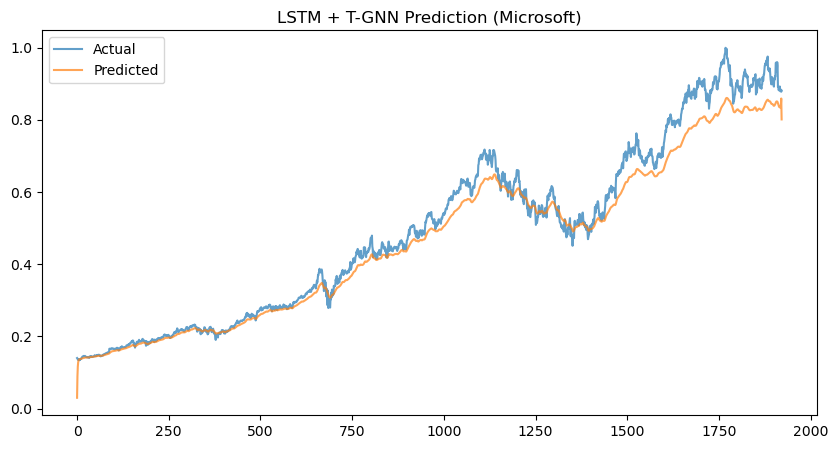


=== Training LSTM + T-GNN for Apple ===
Epoch 10/52, Loss: 0.000244
Epoch 20/52, Loss: 0.000151
Epoch 30/52, Loss: 0.000026
Epoch 40/52, Loss: 0.000008
Epoch 50/52, Loss: 0.000007

Evaluation for Apple:
MSE: 0.000827
R2 Score: 0.987056


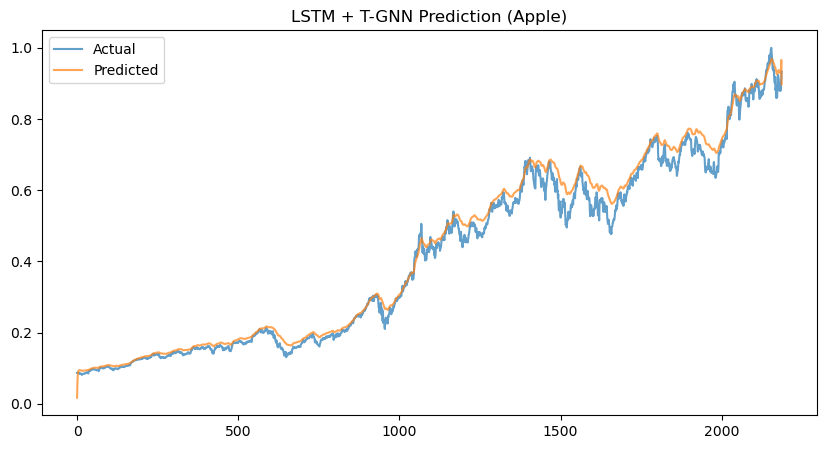

In [12]:
optimized_results = {}

for stock in file_paths:
    params = optimized_params[stock]
    optimized_results[stock] = train_lstm_tgnn(
        stock, 
        hidden_dim=params["hidden_dim"],
        num_layers=params["num_layers"],
        dropout_rate=params["dropout_rate"],
        epochs=params["epochs"],
        learning_rate=params["learning_rate"]
    )

1. Apple performed the best in terms of both MSE and R² score.
- This suggests that Apple’s stock prices may exhibit more stable and predictable patterns compared to NVIDIA and Microsoft.
- The LSTM + T-GNN hybrid was able to model Apple’s stock dynamics with high accuracy.

2. Microsoft and NVIDIA are slightly behind Apple but still show very strong performance.
- The model captures price movements well, but there might be more volatility in NVIDIA’s price action, leading to a slightly higher MSE.

3. The predictions generally follow the actual trends, but some deviation occurs during sharp spikes and dips.
- This is expected due to market fluctuations and potential external factors affecting stock prices.